# Проект: Обучение с учителем: качество модели

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и нам предстоит побыть в роли стажёра в этом отделе. 

Итак, нашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Описание данных**

<u>`market_file.csv`</u>

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

   - `id` — номер покупателя в корпоративной базе данных.
   - `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
   - `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
   - `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
   - `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
   - `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
   - `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
   - `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
   - `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
   - `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
   - `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
   - `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
   - `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
   
<u>`market_money.csv`</u>

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

   - `id` — номер покупателя в корпоративной базе данных.
   - `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
   - `Выручка` — сумма выручки за период.
   
<u>`market_time.csv`</u>

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

   - `id` — номер покупателя в корпоративной базе данных.
   - `Период` — название периода, во время которого зафиксировано общее время.
   - `минут` — значение времени, проведённого на сайте, в минутах.
   
<u>`money.csv`</u>

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

   - `id` — номер покупателя в корпоративной базе данных.
   - `Прибыль` — значение прибыли.

In [1]:
!pip install shap -q

In [2]:
!pip install phik --q

In [3]:
!pip install scikit-learn==1.1.3 -q

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import shap

from phik import phik_matrix

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

# Шаг 1. Загрузка данных

In [5]:
RANDOM_STATE=12345
TEST_SIZE=0.25

In [6]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

In [7]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [8]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [9]:
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [10]:
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

**Вывод**

Все данные представлены корректно и соответствуют описанию. Можно привести столбцы к нижнему регистру, а также обратить внимание на значения в столбцах `Период` датасетов <u>`market_money`</u> и <u>`market_time`</u>. Также стоит учесть значения `Тип сервиса` датасета <u>`market_file`</u>. В целом, на первый взгляд, это всё, что нужно сделать для улучшения качества данных.

# Шаг 2. Предобработка данных

**Таблица <u>`market_file`</u>**

In [11]:
new_columns={
    'id': 'id',
    'Покупательская активность': 'purchasing_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'allow_report',
    'Маркет_актив_6_мес': 'market_active_six_month',
    'Маркет_актив_тек_мес': 'market_active_current_month',
    'Длительность': 'duration',
    'Акционные_покупки': 'promo_purchases',
    'Популярная_категория': 'popular_category',
    'Средний_просмотр_категорий_за_визит': 'average_view_category_visit',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_products',
    'Ошибка_сервиса': 'service_error',
    'Страниц_за_визит': 'page_visit'
            }

market_file = market_file.rename(columns=new_columns)

In [12]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1300 non-null   int64  
 1   purchasing_activity          1300 non-null   object 
 2   service_type                 1300 non-null   object 
 3   allow_report                 1300 non-null   object 
 4   market_active_six_month      1300 non-null   float64
 5   market_active_current_month  1300 non-null   int64  
 6   duration                     1300 non-null   int64  
 7   promo_purchases              1300 non-null   float64
 8   popular_category             1300 non-null   object 
 9   average_view_category_visit  1300 non-null   int64  
 10  unpaid_products              1300 non-null   int64  
 11  service_error                1300 non-null   int64  
 12  page_visit                   1300 non-null   int64  
dtypes: float64(2), int

In [13]:
def analyze_dataframe(df_name):
    df = globals()[df_name]

    print("Первые пять строк таблицы:")
    display(df.head(5))
    print()

    print("Информация о таблице:")
    display(df.info())
    print()

    print("Статистическое описание таблицы:")
    display(df.describe())
    print()

    num_missing_values = df.isnull().sum().sum()
    total_cells = df.size
    percentage_missing = (num_missing_values / total_cells) * 100
    print("Количество пропусков: ", num_missing_values)
    print("Процент пропусков: ", percentage_missing, "%")
    print()

    num_duplicates = df.duplicated().sum()
    percentage_duplicates = (num_duplicates / df.shape[0]) * 100
    print("Количество дубликатов: ", num_duplicates)
    print("Процент дубликатов: ", percentage_duplicates, "%")

In [14]:
analyze_dataframe("market_file")

Первые пять строк таблицы:


id purchasing_activity service_type allow_report  \
0  215348           Снизилась      премиум           да   
1  215349           Снизилась      премиум           да   
2  215350           Снизилась    стандартт          нет   
3  215351           Снизилась    стандартт           да   
4  215352           Снизилась    стандартт          нет   

   market_active_six_month  market_active_current_month  duration  \
0                      3.4                            5       121   
1                      4.4                            4       819   
2                      4.9                            3       539   
3                      3.2                            5       896   
4                      5.1                            3      1064   

   promo_purchases   popular_category  average_view_category_visit  \
0             0.00   Товары для детей                            6   
1             0.75   Товары для детей                            4   
2             0.14  Домашний текстиль                            5   
3             0.99   Товары для детей                            5   
4             0.94   Товары для детей                            3   

   unpaid_products  service_error  page_visit  
0                2              1           5  
1                4              2           5  
2                2              1           5  
3                0              6           4  
4                2              3           2


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1300 non-null   int64  
 1   purchasing_activity          1300 non-null   object 
 2   service_type                 1300 non-null   object 
 3   allow_report                 1300 non-null   object 
 4   market_active_six_month      1300 non-null   float64
 5   market_active_current_month  1300 non-null   int64  
 6   duration                     1300 non-null   int64  
 7   promo_purchases              1300 non-null   float64
 8   popular_category             1300 non-null   object 
 9   average_view_category_visit  1300 non-null   int64  
 10  unpaid_products              1300 non-null   int64  
 11  service_error                1300 non-null   int64  
 12  page_visit                   1300 non-null   int64  


None


Статистическое описание таблицы:


id  market_active_six_month  market_active_current_month  \
count    1300.000000              1300.000000                  1300.000000   
mean   215997.500000                 4.253769                     4.011538   
std       375.421985                 1.014814                     0.696868   
min    215348.000000                 0.900000                     3.000000   
25%    215672.750000                 3.700000                     4.000000   
50%    215997.500000                 4.200000                     4.000000   
75%    216322.250000                 4.900000                     4.000000   
max    216647.000000                 6.600000                     5.000000   

          duration  promo_purchases  average_view_category_visit  \
count  1300.000000      1300.000000                   1300.00000   
mean    601.898462         0.319808                      3.27000   
std     249.856289         0.249843                      1.35535   
min     110.000000         0.000000                      1.00000   
25%     405.500000         0.170000                      2.00000   
50%     606.000000         0.240000                      3.00000   
75%     806.000000         0.300000                      4.00000   
max    1079.000000         0.990000                      6.00000   

       unpaid_products  service_error   page_visit  
count      1300.000000    1300.000000  1300.000000  
mean          2.840000       4.185385     8.176923  
std           1.971451       1.955298     3.978126  
min           0.000000       0.000000     1.000000  
25%           1.000000       3.000000     5.000000  
50%           3.000000       4.000000     8.000000  
75%           4.000000       6.000000    11.000000  
max          10.000000       9.000000    20.000000


Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


In [15]:
market_file['market_active_six_month'] = market_file['market_active_six_month'].astype('int64')

**Таблица <u>`market_money`</u>**

In [16]:
new_columns={
    'id': 'id',
    'Период': 'period',
    'Выручка': 'revenue'

}

market_money = market_money.rename(columns=new_columns)

In [17]:
market_money['period'] = market_money['period'].str.strip()

In [18]:
analyze_dataframe("market_money")

Первые пять строк таблицы:


id               period  revenue
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


Статистическое описание таблицы:


id        revenue
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000


Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


In [19]:
market_money.drop_duplicates(inplace=True)
print(f"Количество дубликатов: {market_money.duplicated().sum()}")
print(f"Процент дубликатов: {(market_money.duplicated().sum()/len(market_money))*100:.2f}%")

Количество дубликатов: 0
Процент дубликатов: 0.00%


**Таблица <u>`market_time`</u>**

In [20]:
new_columns={
    'id': 'id',
    'Период': 'period',
    'минут': 'minutes'

}

market_time = market_time.rename(columns=new_columns)

In [21]:
market_time['period'] = market_time['period'].replace(['предыдцщий_месяц'], 'предыдущий месяц')
market_time['period'] = market_time['period'].replace(['текущий_месяц'], 'текущий месяц')

In [22]:
analyze_dataframe("market_time")

Первые пять строк таблицы:


id            period  minutes
0  215348     текущий месяц       14
1  215348  предыдущий месяц       13
2  215349     текущий месяц       10
3  215349  предыдущий месяц       12
4  215350     текущий месяц       13


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


Статистическое описание таблицы:


id      minutes
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000


Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


**Таблица <u>`money`</u>**

In [23]:
new_columns={
    'id': 'id',
    'Прибыль': 'profit'
}

money = money.rename(columns=new_columns)

In [24]:
analyze_dataframe("money")

Первые пять строк таблицы:


id  profit
0  215348    0.98
1  215349    4.16
2  215350    3.13
3  215351    4.87
4  215352    4.21


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None


Статистическое описание таблицы:


id       profit
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000


Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


**Вывод**

Мы провели реорганизацию столбцов, преобразовали формат данных в столбце `market_file['market_active_six_month']`, а также устранили дубликаты в наборе данных `market_money`. Аномальных значений обнаружено не было.

# Шаг 3. Исследовательский анализ данных

**Таблица <u>`market_file`</u>**

In [25]:
market_file.head()

id purchasing_activity service_type allow_report  \
0  215348           Снизилась      премиум           да   
1  215349           Снизилась      премиум           да   
2  215350           Снизилась    стандартт          нет   
3  215351           Снизилась    стандартт           да   
4  215352           Снизилась    стандартт          нет   

   market_active_six_month  market_active_current_month  duration  \
0                        3                            5       121   
1                        4                            4       819   
2                        4                            3       539   
3                        3                            5       896   
4                        5                            3      1064   

   promo_purchases   popular_category  average_view_category_visit  \
0             0.00   Товары для детей                            6   
1             0.75   Товары для детей                            4   
2             0.14  Домашний текстиль                            5   
3             0.99   Товары для детей                            5   
4             0.94   Товары для детей                            3   

   unpaid_products  service_error  page_visit  
0                2              1           5  
1                4              2           5  
2                2              1           5  
3                0              6           4  
4                2              3           2

In [26]:
num_columns = ['market_active_six_month', 'market_active_current_month', 'duration', 'promo_purchases', 
               'average_view_category_visit', 'unpaid_products', 'service_error', 'page_visit' ]

In [27]:
# Изучим распределение количественных столбцов
def plot_boxplots(dataframe, num_columns):
    num_plots = len(num_columns)
    num_cols = min(2, num_plots)
    num_rows = (num_plots + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))

    for i, column in enumerate(num_columns):
        row = i // num_cols
        col = i % num_cols

        ax = axes[row, col] if num_rows > 1 else axes[col]
        dataframe.boxplot(column=column, ax=ax)
    plt.tight_layout()
    plt.show()

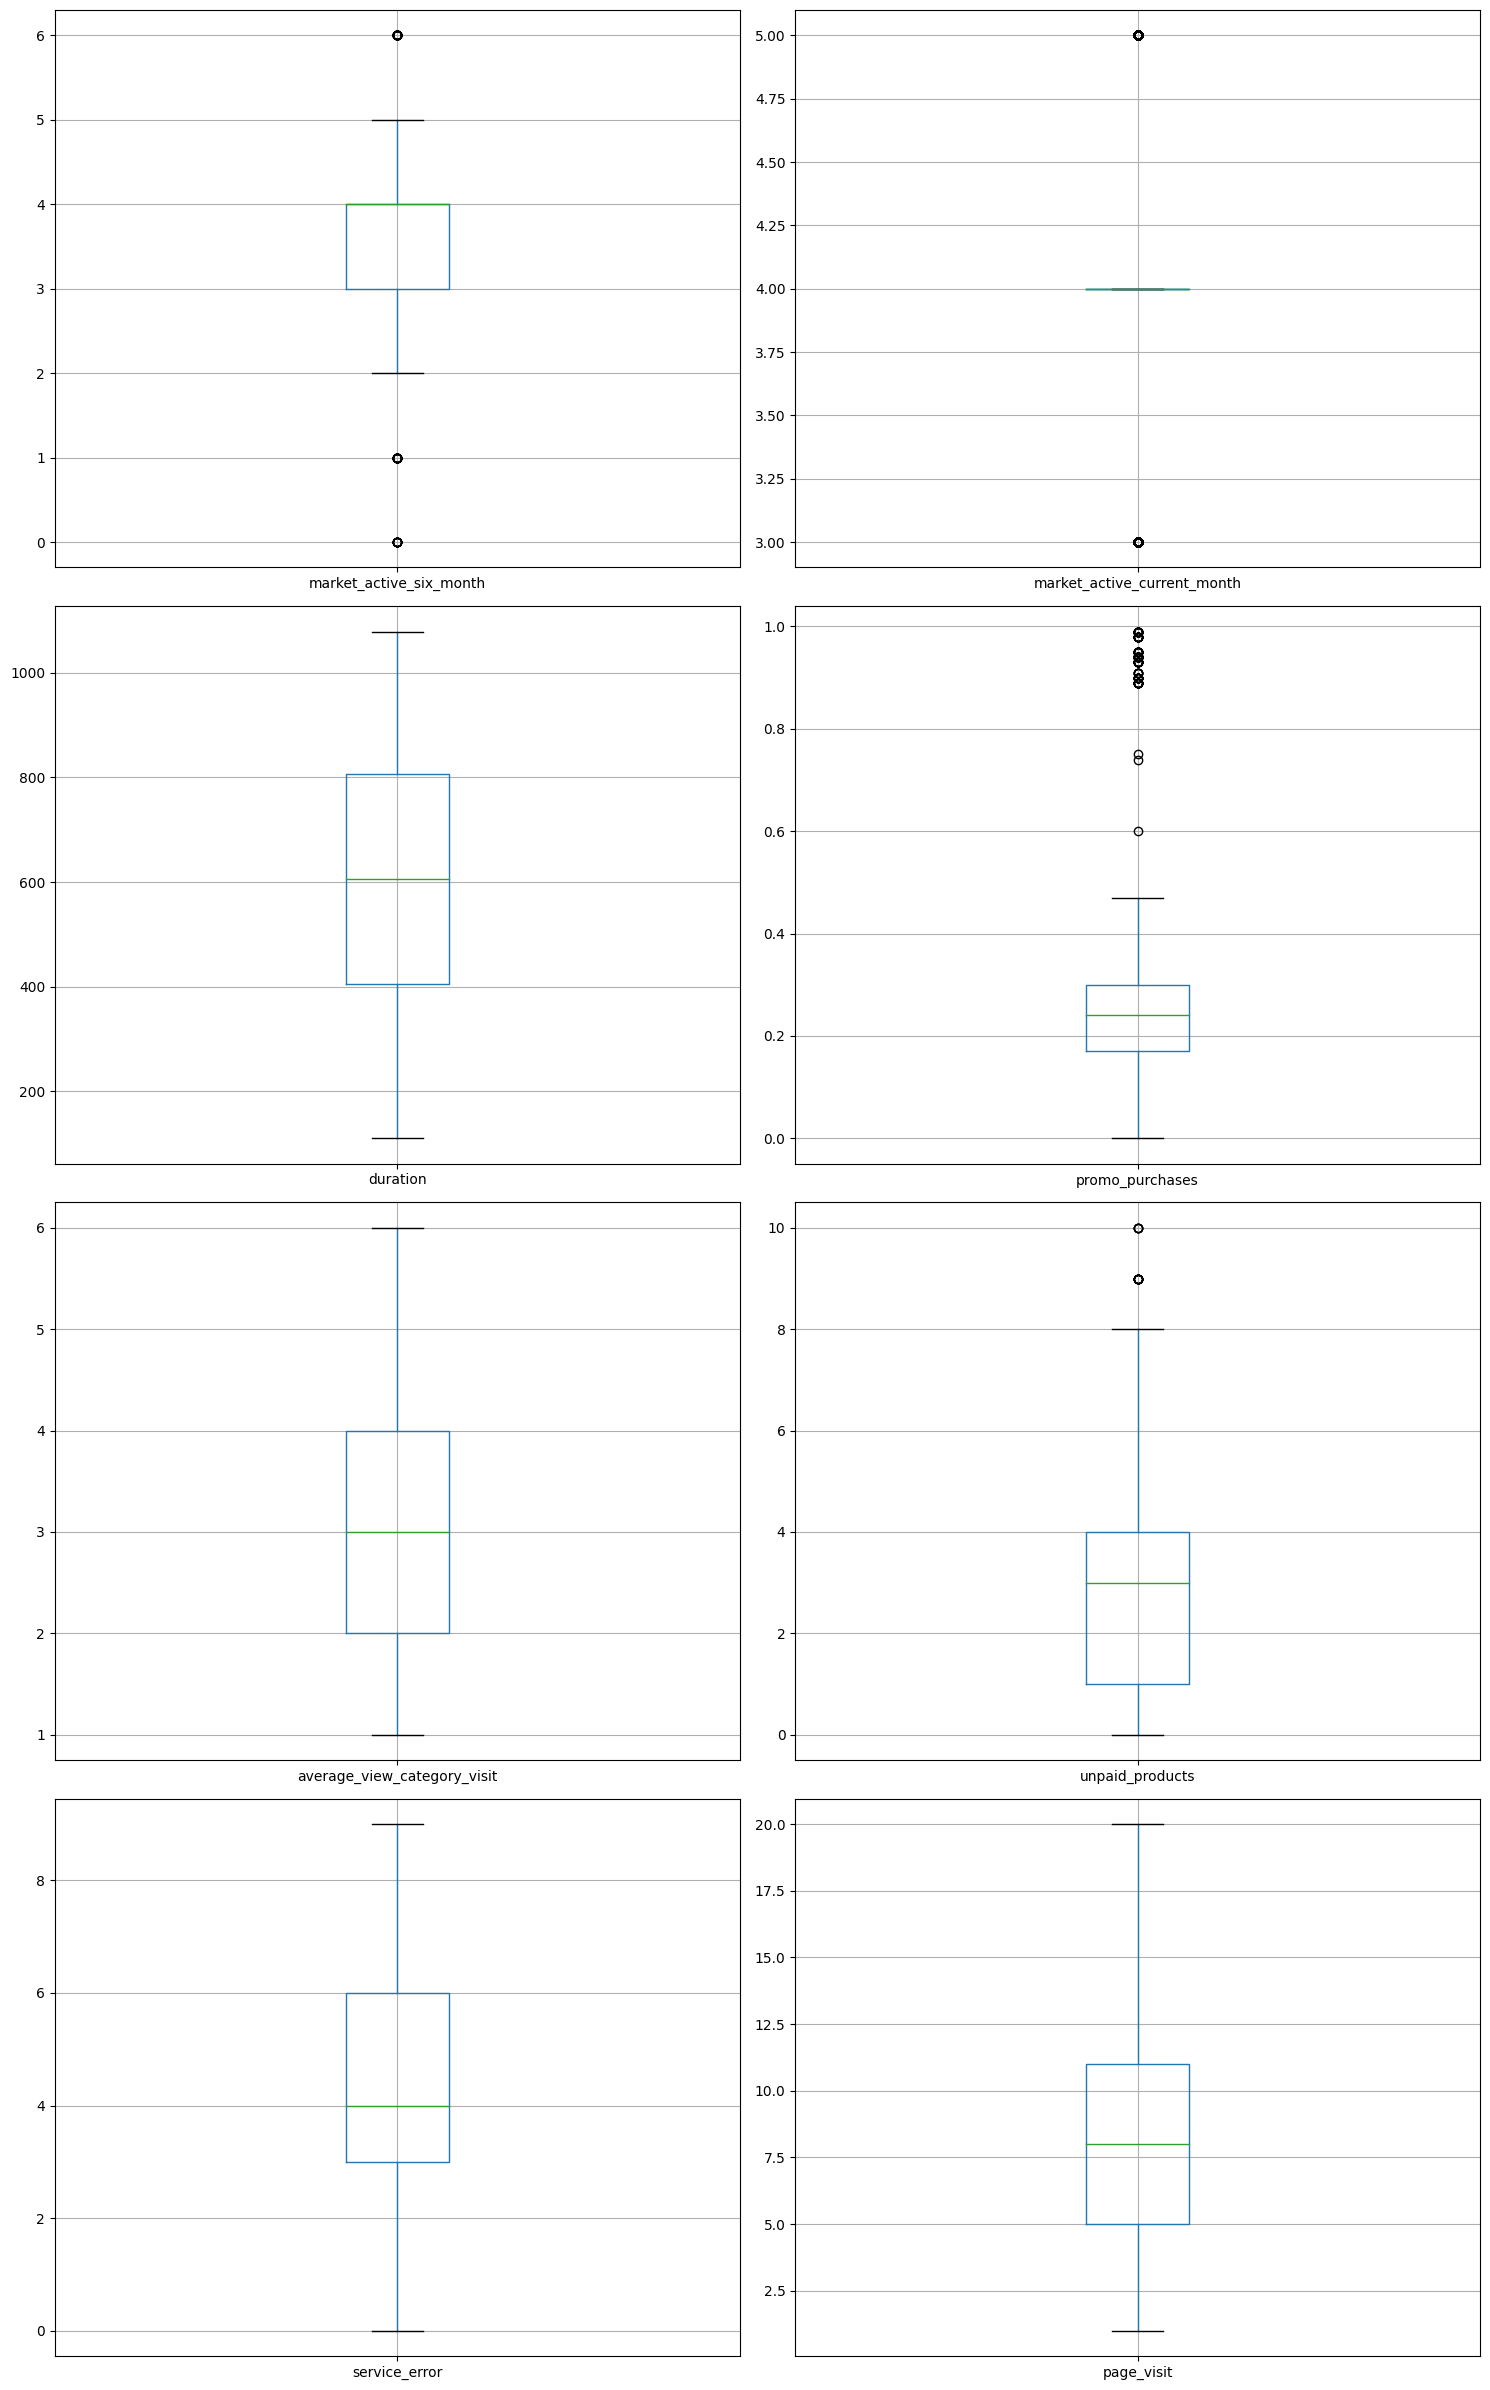

In [28]:
plot_boxplots(market_file, num_columns)

In [29]:
# Напишем функцию для отображения гистограмм количественных столбцов
def plot_histograms(dataframe, num_columns):
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2
    
    fig = make_subplots(rows=rows, cols=2, subplot_titles=num_columns)

    for i, column in enumerate(num_columns):
        row = (i // 2) + 1
        col = (i % 2) + 1
        fig.add_trace(go.Histogram(x=dataframe[column], nbinsx=20), row=row, col=col)

        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)

        fig.update_xaxes(title_text=column, row=row, col=col)
        fig.update_yaxes(title_text='Количество', row=row, col=col)

    fig.update_layout(showlegend=False, height=400*rows, width=900)
    fig.show()

In [30]:
def plot_histograms_one(dataframe, num_columns):
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2

    colors = ['SaddleBrown', 'Peru']  

    fig = make_subplots(rows=rows, cols=2, subplot_titles=num_columns)

    for i, column in enumerate(num_columns):
        row = (i // 2) + 1
        col = (i % 2) + 1
        fig.add_trace(go.Histogram(x=dataframe[dataframe["purchasing_activity"] == "Прежний уровень"][column],
                                   nbinsx=20,
                                   name="Прежний уровень",
                                   marker=dict(color=colors[0])), row=row, col=col)
        fig.add_trace(go.Histogram(x=dataframe[dataframe["purchasing_activity"] == "Снизилась"][column],
                                   nbinsx=20,
                                   name="Снизилась",
                                   marker=dict(color=colors[1])), row=row, col=col)

        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray', row=row, col=col)

        fig.update_xaxes(title_text=column, row=row, col=col)
        fig.update_yaxes(title_text='Count', row=row, col=col)

    fig.update_layout(showlegend=True,
                      height=400*rows, width=1000, title_text="Histograms", legend=dict(traceorder='normal'))

    fig.show()

In [31]:
plot_histograms_one(market_file, num_columns)

In [ ]:
market_file.head()

id purchasing_activity service_type allow_report  \
0  215348           Снизилась      премиум           да   
1  215349           Снизилась      премиум           да   
2  215350           Снизилась    стандартт          нет   
3  215351           Снизилась    стандартт           да   
4  215352           Снизилась    стандартт          нет   

   market_active_six_month  market_active_current_month  duration  \
0                        3                            5       121   
1                        4                            4       819   
2                        4                            3       539   
3                        3                            5       896   
4                        5                            3      1064   

   promo_purchases   popular_category  average_view_category_visit  \
0             0.00   Товары для детей                            6   
1             0.75   Товары для детей                            4   
2             0.14  Домашний текстиль                            5   
3             0.99   Товары для детей                            5   
4             0.94   Товары для детей                            3   

   unpaid_products  service_error  page_visit  
0                2              1           5  
1                4              2           5  
2                2              1           5  
3                0              6           4  
4                2              3           2

In [ ]:
market_file.describe()

id  market_active_six_month  market_active_current_month  \
count    1300.000000              1300.000000                  1300.000000   
mean   215997.500000                 3.796154                     4.011538   
std       375.421985                 1.041473                     0.696868   
min    215348.000000                 0.000000                     3.000000   
25%    215672.750000                 3.000000                     4.000000   
50%    215997.500000                 4.000000                     4.000000   
75%    216322.250000                 4.000000                     4.000000   
max    216647.000000                 6.000000                     5.000000   

          duration  promo_purchases  average_view_category_visit  \
count  1300.000000      1300.000000                   1300.00000   
mean    601.898462         0.319808                      3.27000   
std     249.856289         0.249843                      1.35535   
min     110.000000         0.000000                      1.00000   
25%     405.500000         0.170000                      2.00000   
50%     606.000000         0.240000                      3.00000   
75%     806.000000         0.300000                      4.00000   
max    1079.000000         0.990000                      6.00000   

       unpaid_products  service_error   page_visit  
count      1300.000000    1300.000000  1300.000000  
mean          2.840000       4.185385     8.176923  
std           1.971451       1.955298     3.978126  
min           0.000000       0.000000     1.000000  
25%           1.000000       3.000000     5.000000  
50%           3.000000       4.000000     8.000000  
75%           4.000000       6.000000    11.000000  
max          10.000000       9.000000    20.000000

**Промежуточный вывод**

Изучив графики, мы можем создать портрет **типичного пользователя**. За последние полгода активность маркетинговых коммуникаций составила 4 взаимодействия. Аналогичное количество маркетинговых активностей наблюдается и в течение месяца. Пользователи с нормальной активностью зарегистрированы на сайте от 300 до 650 дней, и распределение равномерно. Большинство пользователей не использует акции. Чаще всего они просматривают три категории товаров за одно посещение сайта. За три месяца они могут не оплатить от одного до пяти товаров в корзине, причём чаще всего не оплачивается один товар. Количество сбоев в сайте при посещении варьируется от 0 до 9, в среднем составляя 4. Обычно за одно посещение просматривается около девяти страниц.

Мы также определили профиль **неактивного пользователя**. Уровень вовлечённости в маркетинговые коммуникации составляет 3 за полгода, при этом количество маркетинговых активностей за месяц равно 4. Большинство пользователей зарегистрировано 800–850 дней назад. Предполагается, что пользователям наскучил сайт. 28–33% пользователей используют акционные товары. Можно предположить, что низкая активность связана с тем, что пользователи предпочитают покупать товары со скидками. За один визит сайта они просматривают две категории товаров. В течение трёх месяцев они могут не оплатить от 1 до 9 товаров, в среднем 3. Количество сбоев в среднем составляет 3. Обычно такие пользователи просматривают 6 страниц за один визит сайта, что логично меньше, чем у среднестатистического пользователя.

In [ ]:
market_file.head()

id purchasing_activity service_type allow_report  \
0  215348           Снизилась      премиум           да   
1  215349           Снизилась      премиум           да   
2  215350           Снизилась    стандартт          нет   
3  215351           Снизилась    стандартт           да   
4  215352           Снизилась    стандартт          нет   

   market_active_six_month  market_active_current_month  duration  \
0                        3                            5       121   
1                        4                            4       819   
2                        4                            3       539   
3                        3                            5       896   
4                        5                            3      1064   

   promo_purchases   popular_category  average_view_category_visit  \
0             0.00   Товары для детей                            6   
1             0.75   Товары для детей                            4   
2             0.14  Домашний текстиль                            5   
3             0.99   Товары для детей                            5   
4             0.94   Товары для детей                            3   

   unpaid_products  service_error  page_visit  
0                2              1           5  
1                4              2           5  
2                2              1           5  
3                0              6           4  
4                2              3           2

In [ ]:
cat_columns = ['purchasing_activity', 'service_type', 'allow_report', 'popular_category']

In [ ]:
def print_unique_values(columns, data):
    for column in columns:
        unique_values = set(data[column])
        display(f"Уникальные значения в '{column}': {unique_values}")

In [ ]:
print_unique_values(cat_columns, market_file)

"Уникальные значения в 'purchasing_activity': {'Прежний уровень', 'Снизилась'}"

"Уникальные значения в 'service_type': {'стандартт', 'премиум', 'стандарт'}"

"Уникальные значения в 'allow_report': {'да', 'нет'}"

"Уникальные значения в 'popular_category': {'Мелкая бытовая техника и электроника', 'Косметика и аксесуары', 'Кухонная посуда', 'Техника для красоты и здоровья', 'Товары для детей', 'Домашний текстиль'}"

In [ ]:
market_file['service_type'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: service_type, dtype: int64

In [ ]:
market_file.loc[market_file['service_type'] == 'стандартт', 'service_type'] = 'стандарт'

In [ ]:
market_file['service_type'].value_counts()

стандарт    924
премиум     376
Name: service_type, dtype: int64

In [ ]:
def create_pie_charts(data, columns):
    colors = ['SaddleBrown', 'Peru']  
    for column in columns:
        counts = data[column].value_counts()

        df = pd.DataFrame({column: counts.index, 'count': counts.values})

        fig = px.pie(df, values='count', names=column, title=f'Круговая диаграмма для {column}', color_discrete_sequence=colors)
        fig.show()

In [ ]:
create_pie_charts(market_file, cat_columns)

Из 6 категорий товаров больший акцент делается на `товары для детей` и `домашний текстиль`, меньший — на `кухонную утварь`.
Около 62 % клиентов сохраняют свой текущий уровень активности. Более 70 % пользуются базовым уровнем обслуживания и готовы получать дополнительные предложения о товарах.

**Таблица <u>`market_money`</u>**

In [ ]:
market_money.head()

id               period  revenue
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [ ]:
num_col = ['revenue']
cat_col = ['period']

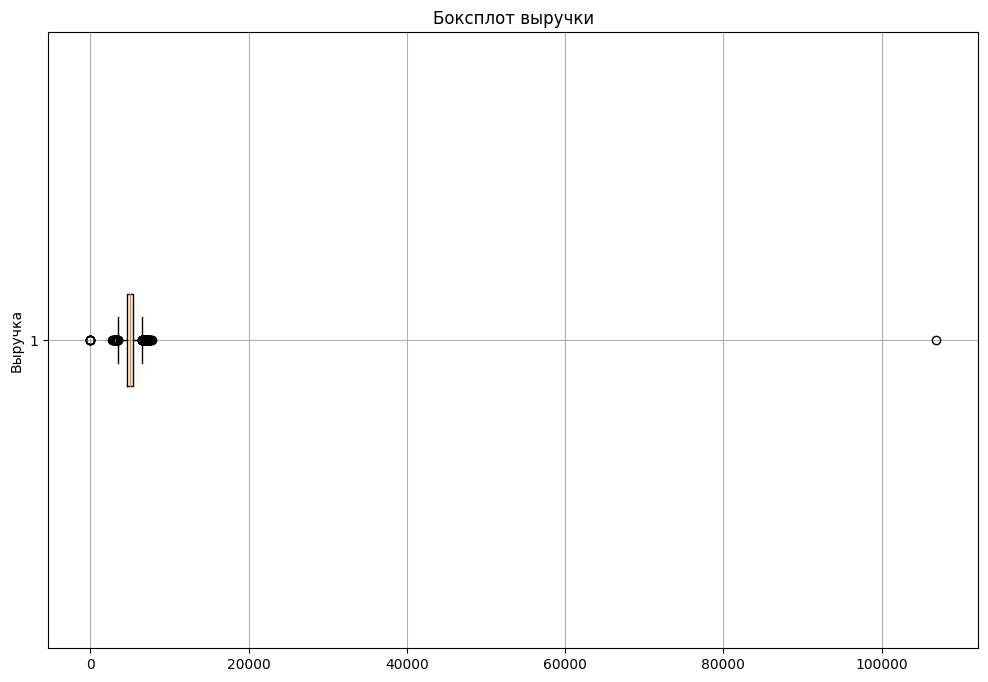

In [ ]:
plt.figure(figsize=(12, 8))
plt.boxplot(market_money['revenue'], vert=False)  
plt.title('Боксплот выручки')
plt.ylabel('Выручка')
plt.grid(True)

plt.show()

In [ ]:
market_money.groupby('period')['revenue'].sum()

period
предыдущий_месяц       6417996.5
препредыдущий_месяц    6272769.0
текущий_месяц          6909449.1
Name: revenue, dtype: float64

In [ ]:
fig = go.Figure()


fig.add_trace(go.Bar(
    x=market_money['period'],
    y=market_money['revenue'],
    marker_line_color='black',  
    marker_line_width=1.5,
    name='Выручка'
))


fig.update_layout(
    xaxis_title='Период',
    yaxis_title='Выручка',
    title='Столбчатая диаграмма выручки по периодам'
)


fig.show()

In [ ]:
plot_histograms(market_money, num_col)

In [ ]:
fig = px.histogram(market_time, x='minutes', nbins=10, facet_col='period', facet_col_wrap=3)

fig.update_layout(
    title='Распределение минут по периодам',
)

fig.update_traces(marker_color='Wheat', marker_line_color='black', marker_line_width=1.5)  

fig.show()

In [ ]:
# Удалим аномальноезначение
market_money.drop(market_money[market_money['revenue'] > 20000].index, inplace=True)

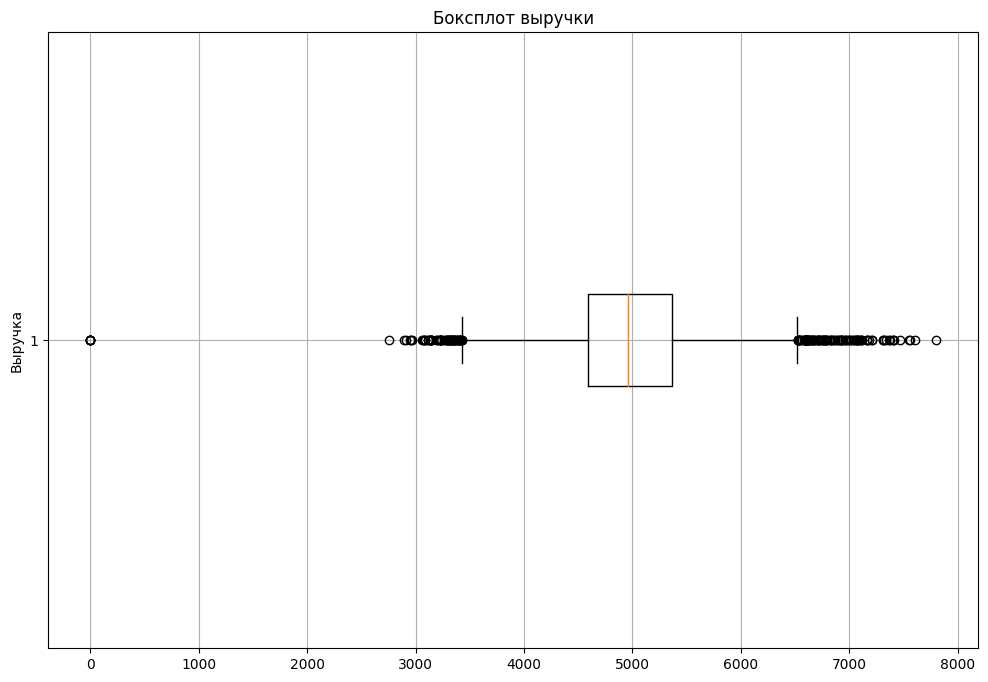

In [ ]:
plt.figure(figsize=(12, 8))
plt.boxplot(market_money['revenue'], vert=False)  
plt.title('Боксплот выручки')
plt.ylabel('Выручка')
plt.grid(True)

plt.show()

In [ ]:
plot_histograms(market_money, num_col)

In [ ]:
count_zero_revenue = len(market_money[market_money['revenue'] == 0])
zero_revenue_rows = market_money[market_money['revenue'] == 0]
print("Количество строк с нулевой выручкой:", count_zero_revenue)
print("Строки с нулевой выручкой:")
display(zero_revenue_rows)

Количество строк с нулевой выручкой: 6
Строки с нулевой выручкой:


id               period  revenue
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0

In [ ]:
# Удалим клиентов с нулевой выручкой
ids_to_remove = zero_revenue_rows['id'].unique()

In [ ]:
market_money = market_money[~market_money['id'].isin(ids_to_remove)]

In [ ]:
plot_histograms(market_money, num_col)

In [ ]:
fig = px.histogram(market_money, x='revenue', nbins=10, facet_col='period', facet_col_wrap=3)
fig.update_traces(marker_color='Wheat', marker_line_color='black', marker_line_width=1)

fig.show()

Самые высокие значения выручки в препредыдущем месяце. В текущем и предыдущем месяцах распределение почти одинаковое.

In [ ]:
print_unique_values(cat_col, market_money)

"Уникальные значения в 'period': {'текущий_месяц', 'препредыдущий_месяц', 'предыдущий_месяц'}"

In [ ]:
create_pie_charts(market_money, cat_col)

**Таблица <u>`market_time`</u>**

In [ ]:
market_time.head()

id            period  minutes
0  215348     текущий месяц       14
1  215348  предыдущий месяц       13
2  215349     текущий месяц       10
3  215349  предыдущий месяц       12
4  215350     текущий месяц       13

In [ ]:
num_col_1 = ['minutes']
cat_col_1 = ['period']

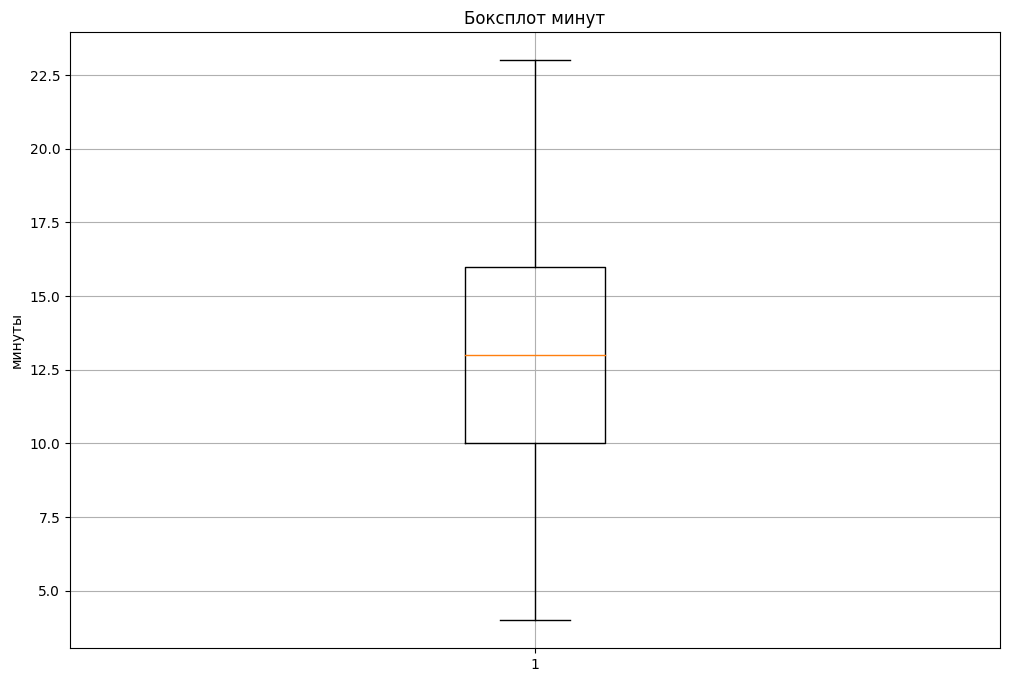

In [ ]:
plt.figure(figsize=(12, 8))
plt.boxplot(market_time['minutes'])
plt.title('Боксплот минут')
plt.ylabel('минуты')
plt.grid(True)

plt.show()

In [ ]:
def plot_histograms(data, num_col, cat_col):
    fig = px.histogram(data, x=num_col[0], color=cat_col[0], nbins=10)
    fig.update_traces(marker_color='Wheat', marker_line_color='black', marker_line_width=1)
    
    fig.show()

plot_histograms(market_time, num_col_1, cat_col_1)

In [ ]:
print_unique_values(cat_col_1, market_time)

"Уникальные значения в 'period': {'предыдущий месяц', 'текущий месяц'}"

- Посетители сайта обычно проводят на нём от 10 до 15 минут.

**Вывод**

Среднестатистический пользователь зарегестрирован на сайте чуть больше полутора года. В течение месяца он сталкивается примерно с четырьмя маркетинговыми активностями, которые предлагает сайт. Обычно этот пользователь не использует специальные предложения или скидки, доступные на сайте.

Во время использования сайта среднестатистический пользователь сталкивается с 4 сбоями в работе сайта и просматривает в среднем 8 страниц за одно посещение. Его интересуют различные категории товаров, такие как `товары для детей`, `домашний текстиль`, `косметика и аксессуары`. Время пребывания пользователя на сайте составляет от 10 до 15 минут.

Следует подчеркнуть, что такие аспекты, как количество дней регистрации на сайте, количество просмотренных категорий за визит, число сбоев и среднее количество просмотренных страниц за посещение сайта, указывают на снижение активности пользователей.

# Шаг 4. Объединение таблиц

In [ ]:
# Создадим отдельные столбцы для каждого из периодов
time_pivot = market_time.pivot_table(index=['id'],columns=['period'],values=['minutes'])
time_pivot.columns = ['minutes_prev_month','minutes_current_month']
time_pivot = time_pivot.reset_index()
time_pivot.head()

id  minutes_prev_month  minutes_current_month
0  215348                  13                     14
1  215349                  12                     10
2  215350                   8                     13
3  215351                  11                     13
4  215352                   8                     11

In [ ]:
money_pivot = market_money.pivot_table(index=['id'],columns=['period'],values=['revenue'])
money_pivot.columns = ['revenue_prev_month', 'revenue_before_prev_month', 'revenue_current_month']
money_pivot = money_pivot.reset_index()
money_pivot.head()

id  revenue_prev_month  revenue_before_prev_month  \
0  215349              5216.0                     4472.0   
1  215350              5457.5                     4826.0   
2  215351              6158.0                     4793.0   
3  215352              5807.5                     4594.0   
4  215353              4738.5                     5124.0   

   revenue_current_month  
0                 4971.6  
1                 5058.4  
2                 6610.4  
3                 5872.5  
4                 5388.5

In [ ]:
money_pivot.isna().sum()

id                           0
revenue_prev_month           0
revenue_before_prev_month    0
revenue_current_month        1
dtype: int64

In [ ]:
# Заполнимпропуск медианным значением
median_revenue = money_pivot['revenue_current_month'].median()
money_pivot['revenue_current_month'].fillna(median_revenue, inplace=True)

In [ ]:
market_file.reset_index(inplace=True,drop=True)
time_pivot.reset_index(inplace=True,drop=True)
money_pivot.reset_index(inplace=True,drop=True)

In [ ]:
# Объединим таблицы
df = market_file.merge(time_pivot, on='id',how='inner').merge(money_pivot, on='id', how='inner')
df.head()

id purchasing_activity service_type allow_report  \
0  215349           Снизилась      премиум           да   
1  215350           Снизилась     стандарт          нет   
2  215351           Снизилась     стандарт           да   
3  215352           Снизилась     стандарт          нет   
4  215353           Снизилась     стандарт           да   

   market_active_six_month  market_active_current_month  duration  \
0                        4                            4       819   
1                        4                            3       539   
2                        3                            5       896   
3                        5                            3      1064   
4                        3                            4       762   

   promo_purchases   popular_category  average_view_category_visit  \
0             0.75   Товары для детей                            4   
1             0.14  Домашний текстиль                            5   
2             0.99   Товары для детей                            5   
3             0.94   Товары для детей                            3   
4             0.26  Домашний текстиль                            4   

   unpaid_products  service_error  page_visit  minutes_prev_month  \
0                4              2           5                  12   
1                2              1           5                   8   
2                0              6           4                  11   
3                2              3           2                   8   
4                1              1           4                  10   

   minutes_current_month  revenue_prev_month  revenue_before_prev_month  \
0                     10              5216.0                     4472.0   
1                     13              5457.5                     4826.0   
2                     13              6158.0                     4793.0   
3                     11              5807.5                     4594.0   
4                     10              4738.5                     5124.0   

   revenue_current_month  
0                 4971.6  
1                 5058.4  
2                 6610.4  
3                 5872.5  
4                 5388.5

In [ ]:
analyze_dataframe("df")

Первые пять строк таблицы:


id purchasing_activity service_type allow_report  \
0  215349           Снизилась      премиум           да   
1  215350           Снизилась     стандарт          нет   
2  215351           Снизилась     стандарт           да   
3  215352           Снизилась     стандарт          нет   
4  215353           Снизилась     стандарт           да   

   market_active_six_month  market_active_current_month  duration  \
0                        4                            4       819   
1                        4                            3       539   
2                        3                            5       896   
3                        5                            3      1064   
4                        3                            4       762   

   promo_purchases   popular_category  average_view_category_visit  \
0             0.75   Товары для детей                            4   
1             0.14  Домашний текстиль                            5   
2             0.99   Товары для детей                            5   
3             0.94   Товары для детей                            3   
4             0.26  Домашний текстиль                            4   

   unpaid_products  service_error  page_visit  minutes_prev_month  \
0                4              2           5                  12   
1                2              1           5                   8   
2                0              6           4                  11   
3                2              3           2                   8   
4                1              1           4                  10   

   minutes_current_month  revenue_prev_month  revenue_before_prev_month  \
0                     10              5216.0                     4472.0   
1                     13              5457.5                     4826.0   
2                     13              6158.0                     4793.0   
3                     11              5807.5                     4594.0   
4                     10              4738.5                     5124.0   

   revenue_current_month  
0                 4971.6  
1                 5058.4  
2                 6610.4  
3                 5872.5  
4                 5388.5


Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1297 non-null   int64  
 1   purchasing_activity          1297 non-null   object 
 2   service_type                 1297 non-null   object 
 3   allow_report                 1297 non-null   object 
 4   market_active_six_month      1297 non-null   int64  
 5   market_active_current_month  1297 non-null   int64  
 6   duration                     1297 non-null   int64  
 7   promo_purchases              1297 non-null   float64
 8   popular_category             1297 non-null   object 
 9   average_view_category_visit  1297 non-null   int64  
 10  unpaid_products              1297 non-null   int64  
 11  service_error                1297 non-null   int64  
 12  page_visit                   1297 non-null   int64  


None


Статистическое описание таблицы:


id  market_active_six_month  market_active_current_month  \
count    1297.000000              1297.000000                  1297.000000   
mean   215998.986893                 3.797224                     4.009252   
std       374.578554                 1.042192                     0.696048   
min    215349.000000                 0.000000                     3.000000   
25%    215675.000000                 3.000000                     4.000000   
50%    215999.000000                 4.000000                     4.000000   
75%    216323.000000                 4.000000                     4.000000   
max    216647.000000                 6.000000                     5.000000   

          duration  promo_purchases  average_view_category_visit  \
count  1297.000000      1297.000000                  1297.000000   
mean    602.993832         0.320547                     3.267540   
std     249.101456         0.249657                     1.354623   
min     121.000000         0.110000                     1.000000   
25%     410.000000         0.170000                     2.000000   
50%     607.000000         0.240000                     3.000000   
75%     806.000000         0.300000                     4.000000   
max    1079.000000         0.990000                     6.000000   

       unpaid_products  service_error   page_visit  minutes_prev_month  \
count      1297.000000    1297.000000  1297.000000         1297.000000   
mean          2.841172       4.184271     8.186584           13.469545   
std           1.973451       1.950973     3.977061            3.936323   
min           0.000000       0.000000     1.000000            5.000000   
25%           1.000000       3.000000     5.000000           11.000000   
50%           3.000000       4.000000     8.000000           13.000000   
75%           4.000000       6.000000    11.000000           17.000000   
max          10.000000       9.000000    20.000000           23.000000   

       minutes_current_month  revenue_prev_month  revenue_before_prev_month  \
count            1297.000000         1297.000000                1297.000000   
mean               13.211257         4948.339630                4836.367772   
std                 4.220222          701.228571                 333.438742   
min                 4.000000         2890.000000                4098.000000   
25%                10.000000         4498.500000                4585.000000   
50%                13.000000         5005.500000                4812.000000   
75%                16.000000         5409.000000                5055.000000   
max                23.000000         6869.500000                5663.000000   

       revenue_current_month  
count            1297.000000  
mean             5238.051234  
std               833.998336  
min              2758.700000  
25%              4706.600000  
50%              5179.950000  
75%              5758.600000  
max              7799.400000


Количество пропусков:  0
Процент пропусков:  0.0 %

Количество дубликатов:  0
Процент дубликатов:  0.0 %


# Шаг 5. Корреляционный анализ

In [ ]:
df

id purchasing_activity service_type allow_report  \
0     215349           Снизилась      премиум           да   
1     215350           Снизилась     стандарт          нет   
2     215351           Снизилась     стандарт           да   
3     215352           Снизилась     стандарт          нет   
4     215353           Снизилась     стандарт           да   
...      ...                 ...          ...          ...   
1292  216643     Прежний уровень     стандарт           да   
1293  216644     Прежний уровень     стандарт          нет   
1294  216645     Прежний уровень     стандарт           да   
1295  216646     Прежний уровень     стандарт           да   
1296  216647     Прежний уровень      премиум           да   

      market_active_six_month  market_active_current_month  duration  \
0                           4                            4       819   
1                           4                            3       539   
2                           3                            5       896   
3                           5                            3      1064   
4                           3                            4       762   
...                       ...                          ...       ...   
1292                        6                            3       318   
1293                        5                            4       454   
1294                        4                            3       586   
1295                        6                            5       645   
1296                        4                            5       906   

      promo_purchases                popular_category  \
0                0.75                Товары для детей   
1                0.14               Домашний текстиль   
2                0.99                Товары для детей   
3                0.94                Товары для детей   
4                0.26               Домашний текстиль   
...               ...                             ...   
1292             0.24  Техника для красоты и здоровья   
1293             0.21               Домашний текстиль   
1294             0.20               Домашний текстиль   
1295             0.12  Техника для красоты и здоровья   
1296             0.94  Техника для красоты и здоровья   

      average_view_category_visit  unpaid_products  service_error  page_visit  \
0                               4                4              2           5   
1                               5                2              1           5   
2                               5                0              6           4   
3                               3                2              3           2   
4                               4                1              1           4   
...                           ...              ...            ...         ...   
1292                            5                3              3          11   
1293                            6                2              3           9   
1294                            3                2              5           7   
1295                            3                3              5           7   
1296                            4                5              3          12   

      minutes_prev_month  minutes_current_month  revenue_prev_month  \
0                     12                     10              5216.0   
1                      8                     13              5457.5   
2                     11                     13              6158.0   
3                      8                     11              5807.5   
4                     10                     10              4738.5   
...                  ...                    ...                 ...   
1292                  14                      7              3664.0   
1293                  12                     11              4729.0   
1294                  12                     18              5160.0   
1295                  18        

In [ ]:
interval_cols  = [
    'market_active_six_month',
    'market_active_current_month',
    'duration',
    'promo_purchases',
    'average_view_category_visit',
    'unpaid_products',
    'service_error',
    'page_visit',
    'minutes_prev_month',
    'minutes_current_month',
    'revenue_prev_month',
    'revenue_before_prev_month',
    'revenue_current_month'
]
corr_matrix = df[interval_cols].phik_matrix()
corr_matrix

interval columns not set, guessing: ['market_active_six_month', 'market_active_current_month', 'duration', 'promo_purchases', 'average_view_category_visit', 'unpaid_products', 'service_error', 'page_visit', 'minutes_prev_month', 'minutes_current_month', 'revenue_prev_month', 'revenue_before_prev_month', 'revenue_current_month']


market_active_six_month  \
market_active_six_month                     1.000000   
market_active_current_month                 0.073702   
duration                                    0.000000   
promo_purchases                             0.274668   
average_view_category_visit                 0.157920   
unpaid_products                             0.202012   
service_error                               0.103439   
page_visit                                  0.272194   
minutes_prev_month                          0.248700   
minutes_current_month                       0.198932   
revenue_prev_month                          0.113142   
revenue_before_prev_month                   0.200733   
revenue_current_month                       0.023964   

                             market_active_current_month  duration  \
market_active_six_month                         0.073702  0.000000   
market_active_current_month                     1.000000  0.174385   
duration                                        0.174385  1.000000   
promo_purchases                                 0.000000  0.000000   
average_view_category_visit                     0.246726  0.187774   
unpaid_products                                 0.143827  0.191923   
service_error                                   0.116310  0.174467   
page_visit                                      0.000000  0.122727   
minutes_prev_month                              0.106879  0.024075   
minutes_current_month                           0.062485  0.100502   
revenue_prev_month                              0.054683  0.125303   
revenue_before_prev_month                       0.000000  0.114058   
revenue_current_month                           0.000000  0.147580   

                             promo_purchases  average_view_category_visit  \
market_active_six_month             0.274668                     0.157920   
market_active_current_month         0.000000                     0.246726   
duration                            0.000000                     0.187774   
promo_purchases                     1.000000                     0.199417   
average_view_category_visit         0.199417                     1.000000   
unpaid_products                     0.237583                     0.325688   
service_error                       0.000000                     0.069908   
page_visit                          0.310741                     0.262610   
minutes_prev_month                  0.262189                     0.159393   
minutes_current_month               0.250014                     0.182708   
revenue_prev_month                  0.065412                     0.100332   
revenue_before_prev_month           0.225681                     0.176770   
revenue_current_month               0.069613                     0.092720   

                             unpaid_products  service_error  page_visit  \
market_active_six_month             0.202012       0.103439    0.272194   
market_active_current_month         0.143827       0.116310    0.000000   
duration                            0.191923       0.174467    0.122727   
promo_purchases                     0.237583       0.000000    0.310741   
average_view_category_visit         0.325688       0.069908    0.262610   
unpaid_products                     1.000000       0.033392    0.363879   
service_error                       0.033392       1.000000    0.182161   
page_visit                          0.363879       0.182161    1.000000   
minutes_prev_month                  0.255982       0.244071    0.478787   
minutes_current_month               0.232121       0.178471    0.382533   
revenue_prev_month                  0.249471       0.000000    0.145680   
revenue_before_prev_month           0.261530       0.140057    0.339672   
revenue_current_month               0.230430       0.000000    0.139529   

                             minutes_prev_month  minutes_current_month  \
market_active_six_month                0.248700            

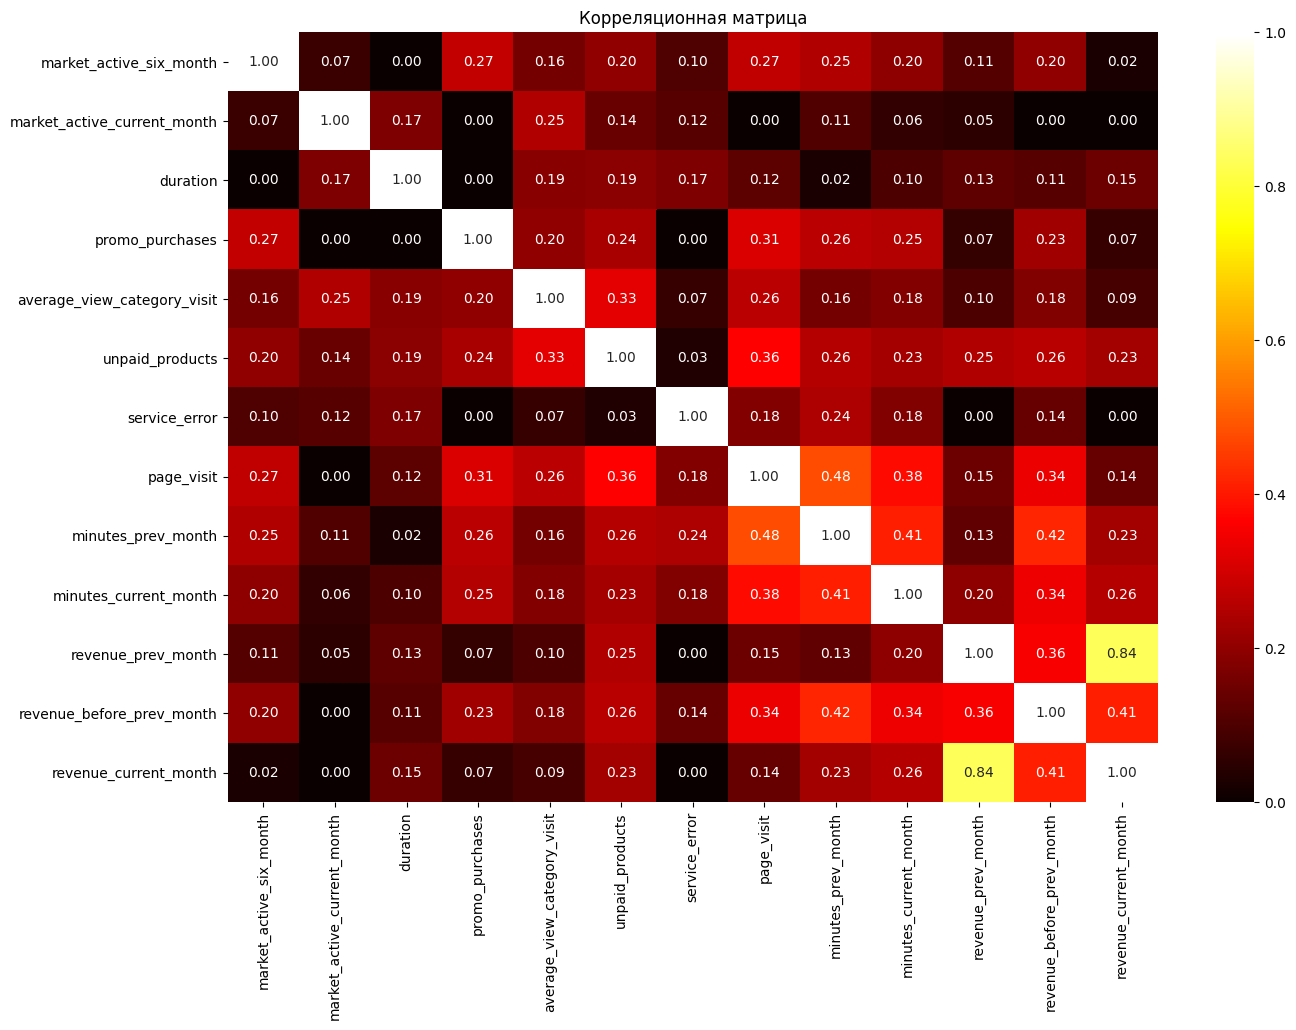

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='hot', fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

In [ ]:
df_full_corr = df.copy()

In [ ]:
df_full_corr = df_full_corr.drop('id', axis=1)

In [ ]:
df_full_corr.phik_matrix()

interval columns not set, guessing: ['market_active_six_month', 'market_active_current_month', 'duration', 'promo_purchases', 'average_view_category_visit', 'unpaid_products', 'service_error', 'page_visit', 'minutes_prev_month', 'minutes_current_month', 'revenue_prev_month', 'revenue_before_prev_month', 'revenue_current_month']


purchasing_activity  service_type  allow_report  \
purchasing_activity                     1.000000      0.132247      0.000000   
service_type                            0.132247      1.000000      0.286278   
allow_report                            0.000000      0.286278      1.000000   
market_active_six_month                 0.366809      0.069051      0.007792   
market_active_current_month             0.000000      0.044796      0.051971   
duration                                0.101767      0.401158      0.253956   
promo_purchases                         0.506991      0.033339      0.017252   
popular_category                        0.298036      0.066285      0.071769   
average_view_category_visit             0.539221      0.186635      0.069322   
unpaid_products                         0.504845      0.120842      0.195442   
service_error                           0.223697      0.076182      0.020464   
page_visit                              0.748769      0.100832      0.041128   
minutes_prev_month                      0.685078      0.131084      0.042350   
minutes_current_month                   0.575662      0.000000      0.000000   
revenue_prev_month                      0.227280      0.000000      0.079830   
revenue_before_prev_month               0.495174      0.068507      0.000000   
revenue_current_month                   0.195470      0.123698      0.062923   

                             market_active_six_month  \
purchasing_activity                         0.366809   
service_type                                0.069051   
allow_report                                0.007792   
market_active_six_month                     1.000000   
market_active_current_month                 0.073702   
duration                                    0.000000   
promo_purchases                             0.274668   
popular_category                            0.091560   
average_view_category_visit                 0.157920   
unpaid_products                             0.202012   
service_error                               0.103439   
page_visit                                  0.272194   
minutes_prev_month                          0.248700   
minutes_current_month                       0.198932   
revenue_prev_month                          0.113142   
revenue_before_prev_month                   0.200733   
revenue_current_month                       0.023964   

                             market_active_current_month  duration  \
purchasing_activity                             0.000000  0.101767   
service_type                                    0.044796  0.401158   
allow_report                                    0.051971  0.253956   
market_active_six_month                         0.073702  0.000000   
market_active_current_month                     1.000000  0.174385   
duration                                        0.174385  1.000000   
promo_purchases                                 0.000000  0.000000   
popular_category                                0.136175  0.000000   
average_view_category_visit                     0.246726  0.187774   
unpaid_products                                 0.143827  0.191923   
service_error                                   0.116310  0.174467   
page_visit                                      0.000000  0.122727   
minutes_prev_month                              0.106879  0.024075   
minutes_current_month                           0.062485  0.100502   
revenue_prev_month                              0.054683  0.125303   
revenue_before_prev_month                       0.000000  0.114058   
revenue_current_month                           0.000000  0.147580   

                             promo_purchases  popular_category  \
purchasing_activity                 0.506991          0.298036   
service_type                        0.033339          0.066285   
allow_report                        0.017252          0.071769   
market_active_six_month             0.274668          

In [ ]:
df_full_corr.phik_matrix().iloc[:,1]

interval columns not set, guessing: ['market_active_six_month', 'market_active_current_month', 'duration', 'promo_purchases', 'average_view_category_visit', 'unpaid_products', 'service_error', 'page_visit', 'minutes_prev_month', 'minutes_current_month', 'revenue_prev_month', 'revenue_before_prev_month', 'revenue_current_month']


purchasing_activity            0.132247
service_type                   1.000000
allow_report                   0.286278
market_active_six_month        0.069051
market_active_current_month    0.044796
duration                       0.401158
promo_purchases                0.033339
popular_category               0.066285
average_view_category_visit    0.186635
unpaid_products                0.120842
service_error                  0.076182
page_visit                     0.100832
minutes_prev_month             0.131084
minutes_current_month          0.000000
revenue_prev_month             0.000000
revenue_before_prev_month      0.068507
revenue_current_month          0.123698
Name: service_type, dtype: float64

In [ ]:
df_lower = df_full_corr[df_full_corr['purchasing_activity'] == 'Снизилась']

In [ ]:
df_lower = df_lower.phik_matrix()
df_lower

interval columns not set, guessing: ['market_active_six_month', 'market_active_current_month', 'duration', 'promo_purchases', 'average_view_category_visit', 'unpaid_products', 'service_error', 'page_visit', 'minutes_prev_month', 'minutes_current_month', 'revenue_prev_month', 'revenue_before_prev_month', 'revenue_current_month']


service_type  allow_report  \
service_type                     1.000000      0.261589   
allow_report                     0.261589      1.000000   
market_active_six_month          0.008349      0.000000   
market_active_current_month      0.000000      0.029343   
duration                         0.400270      0.240149   
promo_purchases                  0.059128      0.000000   
popular_category                 0.102341      0.206417   
average_view_category_visit      0.230606      0.000000   
unpaid_products                  0.164905      0.175760   
service_error                    0.146375      0.000000   
page_visit                       0.173086      0.075327   
minutes_prev_month               0.177267      0.000000   
minutes_current_month            0.000000      0.000000   
revenue_prev_month               0.000000      0.160465   
revenue_before_prev_month        0.216974      0.073060   
revenue_current_month            0.038725      0.000000   

                             market_active_six_month  \
service_type                                0.008349   
allow_report                                0.000000   
market_active_six_month                     1.000000   
market_active_current_month                 0.145083   
duration                                    0.106214   
promo_purchases                             0.301240   
popular_category                            0.137613   
average_view_category_visit                 0.194585   
unpaid_products                             0.102812   
service_error                               0.067359   
page_visit                                  0.282766   
minutes_prev_month                          0.234585   
minutes_current_month                       0.187063   
revenue_prev_month                          0.126579   
revenue_before_prev_month                   0.250265   
revenue_current_month                       0.119566   

                             market_active_current_month  duration  \
service_type                                    0.000000  0.400270   
allow_report                                    0.029343  0.240149   
market_active_six_month                         0.145083  0.106214   
market_active_current_month                     1.000000  0.141746   
duration                                        0.141746  1.000000   
promo_purchases                                 0.000000  0.000000   
popular_category                                0.191797  0.000000   
average_view_category_visit                     0.358168  0.325130   
unpaid_products                                 0.183249  0.269263   
service_error                                   0.164278  0.164611   
page_visit                                      0.172858  0.203362   
minutes_prev_month                              0.233825  0.000000   
minutes_current_month                           0.182517  0.000000   
revenue_prev_month                              0.000000  0.226483   
revenue_before_prev_month                       0.000000  0.223938   
revenue_current_month                           0.091159  0.182891   

                             promo_purchases  popular_category  \
service_type                        0.059128          0.102341   
allow_report                        0.000000          0.206417   
market_active_six_month             0.301240          0.137613   
market_active_current_month         0.000000          0.191797   
duration                            0.000000          0.000000   
promo_purchases                     1.000000          0.162327   
popular_category                    0.162327          1.000000   
average_view_category_visit         0.132861          0.061892   
unpaid_products                     0.150265          0.290352   
service_error                       0.000000          0.058952   
page_visit                          0.317674          0.109843   
minutes_prev_month                  0.324416          0.261351   
minutes_current_month  

In [ ]:
df_full_corr[df_full_corr['purchasing_activity'] == 'Прежний уровень'].phik_matrix()

interval columns not set, guessing: ['market_active_six_month', 'market_active_current_month', 'duration', 'promo_purchases', 'average_view_category_visit', 'unpaid_products', 'service_error', 'page_visit', 'minutes_prev_month', 'minutes_current_month', 'revenue_prev_month', 'revenue_before_prev_month', 'revenue_current_month']


service_type  allow_report  \
service_type                     1.000000      0.293044   
allow_report                     0.293044      1.000000   
market_active_six_month          0.000000      0.055826   
market_active_current_month      0.056050      0.067547   
duration                         0.395860      0.234514   
promo_purchases                  0.000000      0.063418   
popular_category                 0.000000      0.000000   
average_view_category_visit      0.133683      0.115093   
unpaid_products                  0.069945      0.170493   
service_error                    0.000000      0.024660   
page_visit                       0.103943      0.000000   
minutes_prev_month               0.000000      0.000000   
minutes_current_month            0.172217      0.000000   
revenue_prev_month               0.158301      0.000000   
revenue_before_prev_month        0.000000      0.030468   
revenue_current_month            0.115690      0.000000   

                             market_active_six_month  \
service_type                                0.000000   
allow_report                                0.055826   
market_active_six_month                     1.000000   
market_active_current_month                 0.127725   
duration                                    0.000000   
promo_purchases                             0.203596   
popular_category                            0.000000   
average_view_category_visit                 0.000000   
unpaid_products                             0.066353   
service_error                               0.110863   
page_visit                                  0.028990   
minutes_prev_month                          0.000000   
minutes_current_month                       0.084958   
revenue_prev_month                          0.275302   
revenue_before_prev_month                   0.103995   
revenue_current_month                       0.000000   

                             market_active_current_month  duration  \
service_type                                    0.056050  0.395860   
allow_report                                    0.067547  0.234514   
market_active_six_month                         0.127725  0.000000   
market_active_current_month                     1.000000  0.157241   
duration                                        0.157241  1.000000   
promo_purchases                                 0.056968  0.000000   
popular_category                                0.254070  0.018976   
average_view_category_visit                     0.205234  0.028660   
unpaid_products                                 0.147220  0.025546   
service_error                                   0.146153  0.224556   
page_visit                                      0.000000  0.000000   
minutes_prev_month                              0.000000  0.000000   
minutes_current_month                           0.073355  0.187399   
revenue_prev_month                              0.000000  0.000000   
revenue_before_prev_month                       0.000000  0.002658   
revenue_current_month                           0.000000  0.227522   

                             promo_purchases  popular_category  \
service_type                        0.000000          0.000000   
allow_report                        0.063418          0.000000   
market_active_six_month             0.203596          0.000000   
market_active_current_month         0.056968          0.254070   
duration                            0.000000          0.018976   
promo_purchases                     1.000000          0.000000   
popular_category                    0.000000          1.000000   
average_view_category_visit         0.000000          0.234219   
unpaid_products                     0.032153          0.239175   
service_error                       0.030268          0.000000   
page_visit                          0.000000          0.155694   
minutes_prev_month                  0.000000          0.146152   
minutes_current_month  

In [ ]:
df_project = df_full_corr

In [ ]:
df_project.head()

purchasing_activity service_type allow_report  market_active_six_month  \
0           Снизилась      премиум           да                        4   
1           Снизилась     стандарт          нет                        4   
2           Снизилась     стандарт           да                        3   
3           Снизилась     стандарт          нет                        5   
4           Снизилась     стандарт           да                        3   

   market_active_current_month  duration  promo_purchases   popular_category  \
0                            4       819             0.75   Товары для детей   
1                            3       539             0.14  Домашний текстиль   
2                            5       896             0.99   Товары для детей   
3                            3      1064             0.94   Товары для детей   
4                            4       762             0.26  Домашний текстиль   

   average_view_category_visit  unpaid_products  service_error  page_visit  \
0                            4                4              2           5   
1                            5                2              1           5   
2                            5                0              6           4   
3                            3                2              3           2   
4                            4                1              1           4   

   minutes_prev_month  minutes_current_month  revenue_prev_month  \
0                  12                     10              5216.0   
1                   8                     13              5457.5   
2                  11                     13              6158.0   
3                   8                     11              5807.5   
4                  10                     10              4738.5   

   revenue_before_prev_month  revenue_current_month  
0                     4472.0                 4971.6  
1                     4826.0                 5058.4  
2                     4793.0                 6610.4  
3                     4594.0                 5872.5  
4                     5124.0                 5388.5

**Вывод**

Можно сказать, что мультиколлинеарность имеет место, когда коэффициент корреляции между объясняющими переменными составляет 0,9 и более. Все признаки коррелируют в пределах нормы. Наблюдается высокая зависимость между выручкой за предыдущий месяц и выручкой в текущем месяце, однако она ниже 0,9, поэтому её можно оставить.

# Шаг 6. Использование пайплайнов

In [ ]:
df_project.loc[df['purchasing_activity'] == 'Снизилась', 'purchasing_activity'] = 1
df_project.loc[df['purchasing_activity'] == 'Прежний уровень', 'purchasing_activity'] = 0

In [ ]:
df_project['purchasing_activity'] = df_project['purchasing_activity'].astype('int64')

In [ ]:
df_project.isna().sum()

purchasing_activity            0
service_type                   0
allow_report                   0
market_active_six_month        0
market_active_current_month    0
duration                       0
promo_purchases                0
popular_category               0
average_view_category_visit    0
unpaid_products                0
service_error                  0
page_visit                     0
minutes_prev_month             0
minutes_current_month          0
revenue_prev_month             0
revenue_before_prev_month      0
revenue_current_month          0
dtype: int64

In [ ]:
df_project.shape

(1297, 17)

In [ ]:
# Разделим данные на выборки
df_train, df_test = train_test_split(df_project, test_size=0.25, random_state=RANDOM_STATE, 
                                     stratify=df_project['purchasing_activity'])

In [ ]:
X_train = df_train.drop(['purchasing_activity'], axis=1)
y_train = df_train['purchasing_activity']
X_test = df_test.drop(['purchasing_activity'], axis=1)
y_test = df_test['purchasing_activity']

In [ ]:
print('Размер тренировочной выборки', df_train.shape)

Размер тренировочной выборки (972, 17)


In [ ]:
print('Размер тестовой выборки', df_test.shape)

Размер тестовой выборки (325, 17)


In [ ]:
df_project.columns

Index(['purchasing_activity', 'service_type', 'allow_report',
       'market_active_six_month', 'market_active_current_month', 'duration',
       'promo_purchases', 'popular_category', 'average_view_category_visit',
       'unpaid_products', 'service_error', 'page_visit', 'minutes_prev_month',
       'minutes_current_month', 'revenue_prev_month',
       'revenue_before_prev_month', 'revenue_current_month'],
      dtype='object')

In [ ]:
df_project['service_type'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [ ]:
df_project.head()

purchasing_activity service_type allow_report  market_active_six_month  \
0                    1      премиум           да                        4   
1                    1     стандарт          нет                        4   
2                    1     стандарт           да                        3   
3                    1     стандарт          нет                        5   
4                    1     стандарт           да                        3   

   market_active_current_month  duration  promo_purchases   popular_category  \
0                            4       819             0.75   Товары для детей   
1                            3       539             0.14  Домашний текстиль   
2                            5       896             0.99   Товары для детей   
3                            3      1064             0.94   Товары для детей   
4                            4       762             0.26  Домашний текстиль   

   average_view_category_visit  unpaid_products  service_error  page_visit  \
0                            4                4              2           5   
1                            5                2              1           5   
2                            5                0              6           4   
3                            3                2              3           2   
4                            4                1              1           4   

   minutes_prev_month  minutes_current_month  revenue_prev_month  \
0                  12                     10              5216.0   
1                   8                     13              5457.5   
2                  11                     13              6158.0   
3                   8                     11              5807.5   
4                  10                     10              4738.5   

   revenue_before_prev_month  revenue_current_month  
0                     4472.0                 4971.6  
1                     4826.0                 5058.4  
2                     4793.0                 6610.4  
3                     4594.0                 5872.5  
4                     5124.0                 5388.5

In [ ]:
ohe_columns = [
     'allow_report', 'popular_category'
]

ord_columns = ['service_type']
num_columns = ['market_active_six_month', 'market_active_current_month', 'duration', 
               'promo_purchases', 'average_view_category_visit', 'unpaid_products', 'service_error', 'page_visit', 
               'minutes_prev_month', 'minutes_current_month', 'revenue_before_prev_month', 'revenue_prev_month', 'revenue_current_month']

ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
    ]
)

ord_pipe = Pipeline(
    [
        ('ord',  OrdinalEncoder(categories=[['стандарт', 'премиум']]))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# Создадим пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },


    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1',
            class_weight = 'balanced'
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
        {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__kernel': ['rbf', 'poly', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

    },
]

Мы будем использовать следующие модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()`, `SVC()`. Чтобы определить лучшую модель, мы применим метрику `ROC-AUC`. `ROC-AUC` хорошо подходит для работы с несбалансированными классами.

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [ ]:
X_train.head()

service_type allow_report  market_active_six_month  \
1234     стандарт          нет                        5   
1224      премиум           да                        4   
899      стандарт           да                        4   
71       стандарт           да                        4   
570      стандарт          нет                        3   

      market_active_current_month  duration  promo_purchases  \
1234                            3       134             0.25   
1224                            4       482             0.25   
899                             5       869             0.13   
71                              4       503             0.25   
570                             3       744             0.17   

           popular_category  average_view_category_visit  unpaid_products  \
1234       Товары для детей                            4                4   
1224  Косметика и аксесуары                            3                2   
899         Кухонная посуда                            5                1   
71         Товары для детей                            2                3   
570        Товары для детей                            2                1   

      service_error  page_visit  minutes_prev_month  minutes_current_month  \
1234              2           9                  16                     16   
1224              2           9                   8                     22   
899               8          16                  19                     15   
71                1           6                   6                     12   
570               4          15                  20                     12   

      revenue_prev_month  revenue_before_prev_month  revenue_current_month  
1234              3853.0                     4661.0                 4683.7  
1224              5567.0                     5483.0                 5769.8  
899               5068.5                     4377.0                 5797.8  
71                4995.0                     4455.0                 4668.7  
570               4618.5                     5208.0                 4237.6

In [ ]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['allow_report',
                                                                                'popular_category']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['стандарт',
                                                                                                                            'премиум']]))]),
                                                                               ['servic...
                                                                       random_state=12345,
                                                                       solver='liblinear')],
                                         'models__C': [0.001, 0.01, 0.1, 1, 10,
                                                       100, 1000],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=12345)],
                                         'models__kernel': ['rbf', 'poly',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=12345, scoring='roc_auc')

In [ ]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['allow_report',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                  

In [ ]:
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9006780613063714


**Вывод**

Лучшей моделью на тренировочной выборке оказалась `KNeighborsClassifier` (n_neighbors=8), ее `roc_auc` равен: 0.907

Метрика `ROC-AUC` на тестовой выборке: 0.897

# Шаг 7. Анализ важности признаков

In [ ]:
best_model = randomized_search.best_estimator_
kn_model = best_model.named_steps['models']

In [ ]:
X_train_2 = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = best_model.named_steps['preprocessor'].transform(X_test)

In [ ]:
explainer = shap.Explainer(kn_model.predict_proba, X_train_2)

In [ ]:
explainer = shap.Explainer(kn_model.predict_proba, X_train_2)
shap_values = explainer(X_test_2)

PermutationExplainer explainer: 326it [04:22,  1.22it/s]                                                               


In [ ]:
features_out = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist() + num_columns + ord_columns

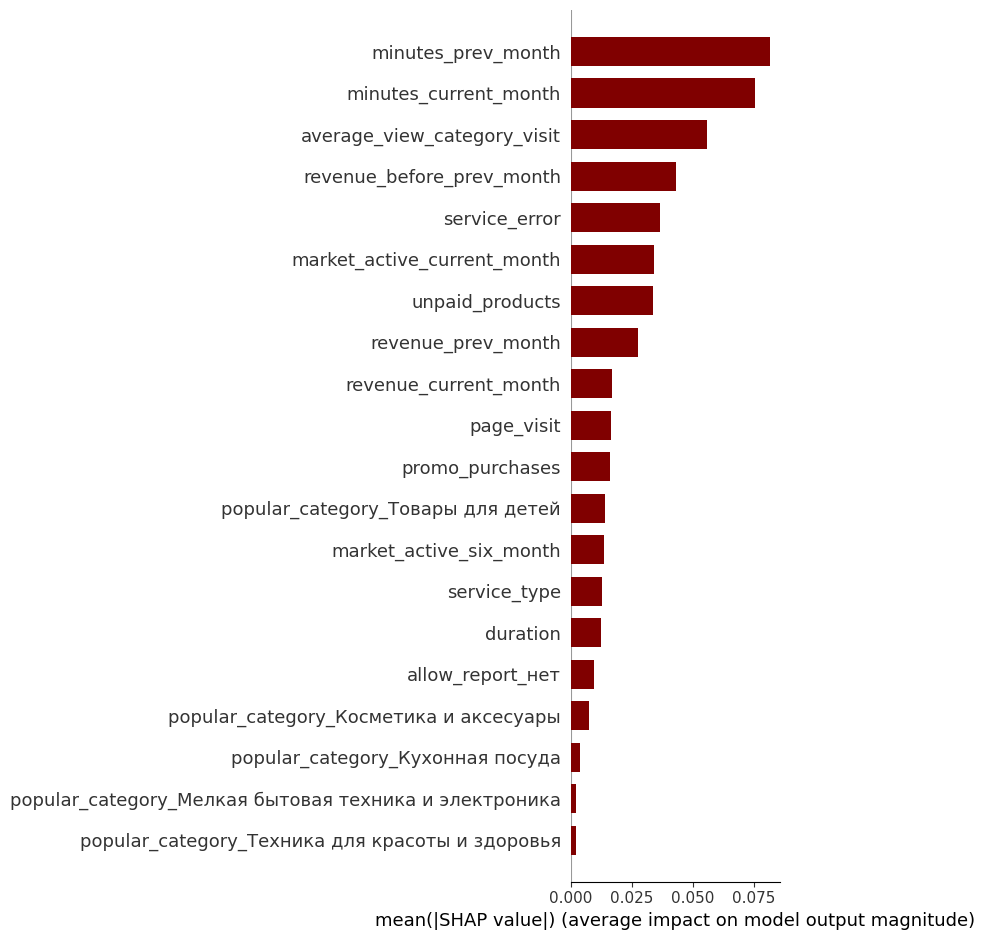

In [ ]:
shap.summary_plot(shap_values[:, :, 1], X_test_2, plot_type="bar", feature_names=features_out, color='Maroon')

**Вывод**

Наибольшее воздействие на модель оказывают количество посещаемых страниц пользователя за визит и количество минут, проведенных им на сайте в предыдущем месяце. Далее следует учитывать акционные покупки, средний просмотр категорий за визит, минуты, проведенные на сайте в текущем месяце, и выручку за предыдущий месяц.

Наименьшее воздействие на модель оказывают категории товаров и количество маркетинговых коммуникаций в текущем месяце. Следовательно, рекомендуется исключить данные признаки из модели, а на те, которые оказывают наибольшее воздействие, обратить особое внимание при принятии решений. Из полученных данных можно сделать вывод, что посещаемость сайта и время, проведенное на нем, сильнее всего *коррелируют* на активность пользователей, поэтому эти факторы следует учитывать при принятии решений.

# Шаг 8. Сегментация покупателей

In [ ]:
# Соеденим данные прибыли
df_segment = pd.merge(df, money)
df_segment[['id', 'profit']]

id  profit
0     215349    4.16
1     215350    3.13
2     215351    4.87
3     215352    4.21
4     215353    3.95
...      ...     ...
1292  216643    4.44
1293  216644    6.11
1294  216645    3.29
1295  216646    4.03
1296  216647    3.28

[1297 rows x 2 columns]

In [ ]:
df_segment['revenue_current_month'] = df_project['revenue_current_month']

In [ ]:
df_segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1297 non-null   int64  
 1   purchasing_activity          1297 non-null   object 
 2   service_type                 1297 non-null   object 
 3   allow_report                 1297 non-null   object 
 4   market_active_six_month      1297 non-null   int64  
 5   market_active_current_month  1297 non-null   int64  
 6   duration                     1297 non-null   int64  
 7   promo_purchases              1297 non-null   float64
 8   popular_category             1297 non-null   object 
 9   average_view_category_visit  1297 non-null   int64  
 10  unpaid_products              1297 non-null   int64  
 11  service_error                1297 non-null   int64  
 12  page_visit                   1297 non-null   int64  
 13  minutes_prev_month

In [ ]:
probabilities = best_model.predict_proba(df_segment)[:, 1]

In [ ]:
df_segment['probability_decrease_activity'] = probabilities

In [ ]:
df_segment.sample(5)

id purchasing_activity service_type allow_report  \
1139  216490     Прежний уровень     стандарт           да   
1168  216519     Прежний уровень     стандарт           да   
1287  216638     Прежний уровень     стандарт          нет   
623   215974     Прежний уровень     стандарт           да   
973   216324     Прежний уровень      премиум           да   

      market_active_six_month  market_active_current_month  duration  \
1139                        4                            4       832   
1168                        4                            5       937   
1287                        1                            3       930   
623                         5                            4       458   
973                         4                            5       509   

      promo_purchases                      popular_category  \
1139             0.24  Мелкая бытовая техника и электроника   
1168             0.11                 Косметика и аксесуары   
1287             0.29  Мелкая бытовая техника и электроника   
623              0.20                     Домашний текстиль   
973              0.25  Мелкая бытовая техника и электроника   

      average_view_category_visit  unpaid_products  service_error  page_visit  \
1139                            3                1              5           8   
1168                            4                2              2           6   
1287                            2                0              4          16   
623                             5                1              6          13   
973                             3                5              4           9   

      minutes_prev_month  minutes_current_month  revenue_prev_month  \
1139                  19                     11              4623.0   
1168                  15                     13              5531.0   
1287                  11                     14              3234.0   
623                   19                      7              4309.5   
973                   19                     20              4852.5   

      revenue_before_prev_month  revenue_current_month  profit  \
1139                     5538.0                 3960.0    3.70   
1168                     4979.0                 6139.4    3.21   
1287                     4613.0                 4557.4    3.63   
623                      4899.0                 3928.6    3.96   
973                      4473.0                 5311.4    0.86   

      probability_decrease_activity  
1139                       0.165881  
1168                       0.174635  
1287                       0.165767  
623                        0.028735  
973                        0.142333

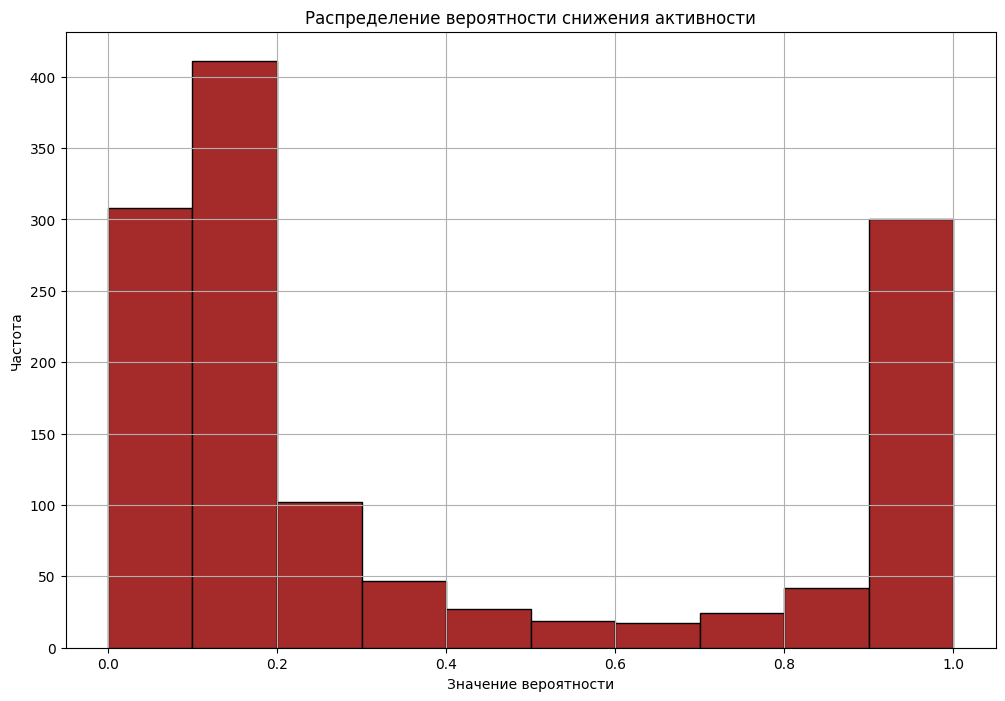

In [ ]:
# Рассчитаем порог
plt.figure(figsize=(12, 8)) 
plt.hist(df_segment['probability_decrease_activity'], bins=10, color='Brown', edgecolor='black')
plt.title("Распределение вероятности снижения активности")
plt.xlabel("Значение вероятности")
plt.ylabel("Частота")
plt.grid(True)

plt.show()

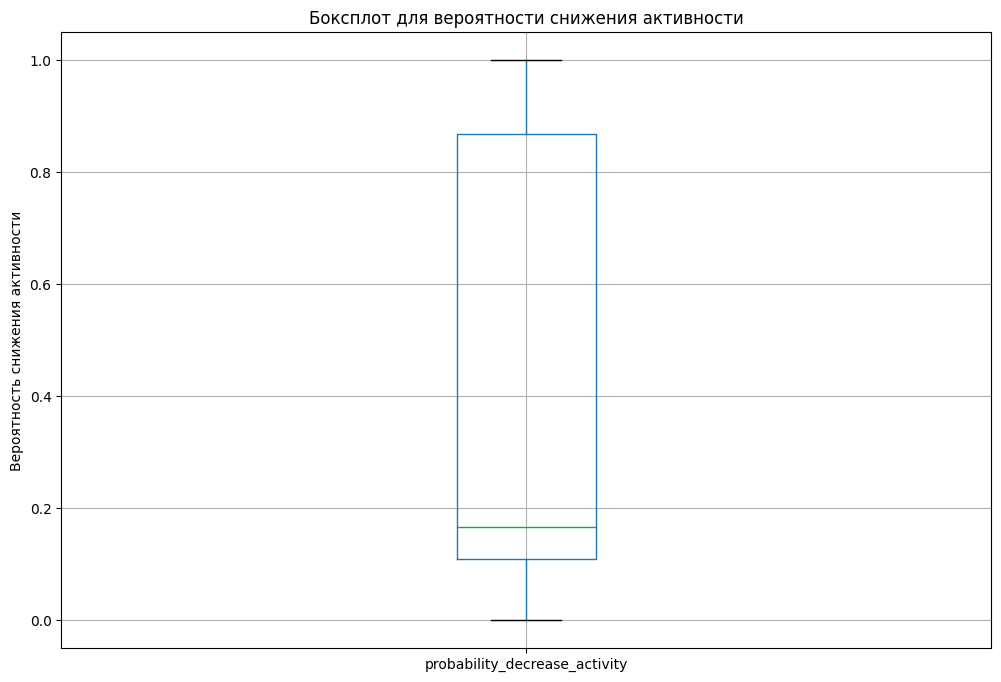

In [ ]:
plt.figure(figsize=(12, 8))
df_segment['probability_decrease_activity'].plot(kind='box')
plt.title('Боксплот для вероятности снижения активности')
plt.ylabel('Вероятность снижения активности')
plt.grid(True)

plt.show()

In [ ]:
percentile = df_segment['probability_decrease_activity'].quantile(0.75)
percentile

0.8680049791726526

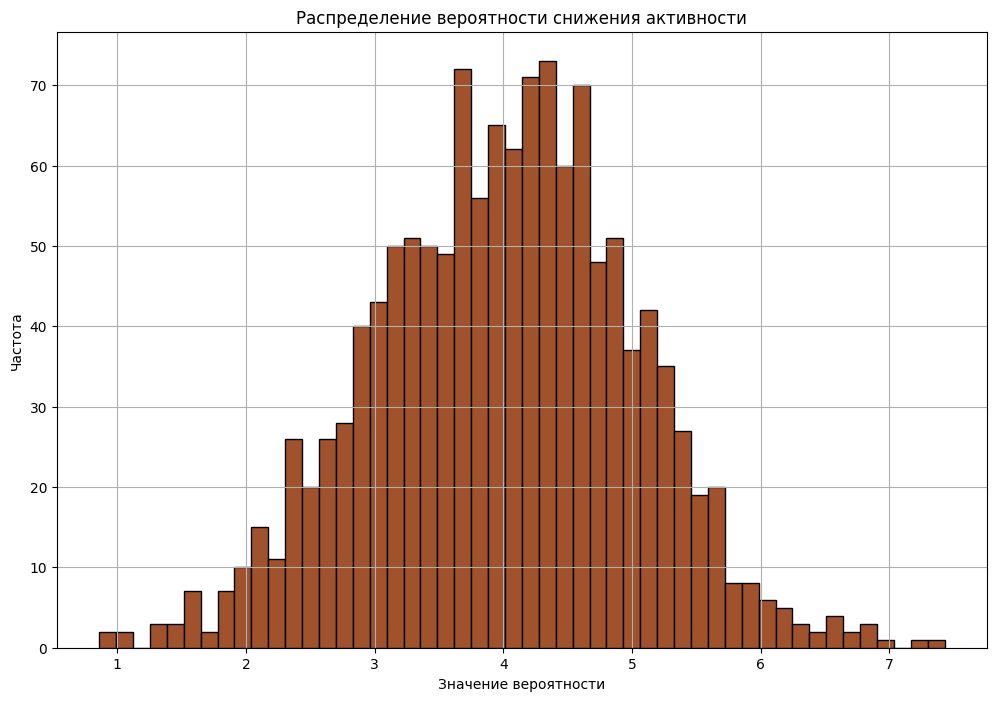

In [ ]:
plt.figure(figsize=(12, 8)) 
plt.hist(df_segment['profit'], bins=50, color='Sienna', edgecolor='black')
plt.title("Распределение вероятности снижения активности")
plt.xlabel("Значение вероятности")
plt.ylabel("Частота")
plt.grid(True)

plt.show()

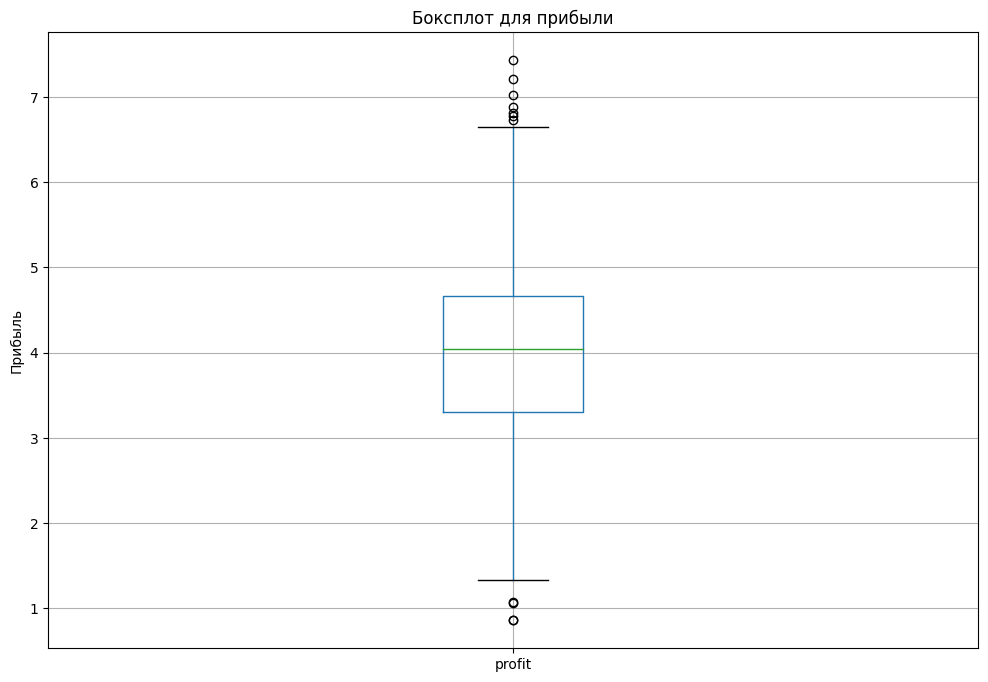

In [ ]:
plt.figure(figsize=(12, 8))
df_segment['profit'].plot(kind='box')
plt.title('Боксплот для прибыли')
plt.ylabel('Прибыль')
plt.grid(True)

plt.show()

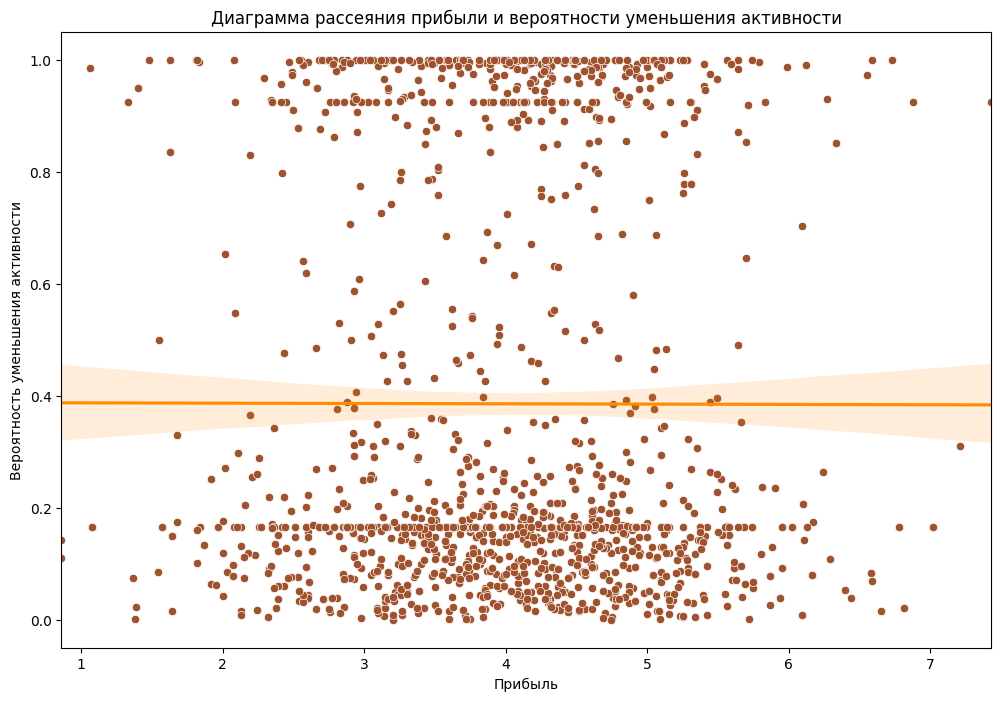

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='profit', y='probability_decrease_activity', data=df_segment, color='Sienna')

sns.regplot(x='profit', y='probability_decrease_activity', data=df_segment, scatter=False, color='DarkOrange')

plt.title('Диаграмма рассеяния прибыли и вероятности уменьшения активности')
plt.xlabel('Прибыль')
plt.ylabel('Вероятность уменьшения активности')

plt.show()

In [ ]:
df_segment['profit'].mean()

3.9976098689282957

In [ ]:
percentile = df_segment['profit'].quantile(0.7)
percentile

4.55

Определим, что высокие показатели прибыли соответствуют значениям выше третьего квартиля, а вероятность снижения активности превышает 0.5.

In [ ]:
df_high_income = df_segment[(df_segment['probability_decrease_activity'] >= 0.5) & (df_segment['profit'] >= 4.55)]

In [ ]:
df_high_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 2 to 1032
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             118 non-null    int64  
 1   purchasing_activity            118 non-null    object 
 2   service_type                   118 non-null    object 
 3   allow_report                   118 non-null    object 
 4   market_active_six_month        118 non-null    int64  
 5   market_active_current_month    118 non-null    int64  
 6   duration                       118 non-null    int64  
 7   promo_purchases                118 non-null    float64
 8   popular_category               118 non-null    object 
 9   average_view_category_visit    118 non-null    int64  
 10  unpaid_products                118 non-null    int64  
 11  service_error                  118 non-null    int64  
 12  page_visit                     118 non-null    in

В сегменте получилось 118 пользователь, их прибыль больше, чем у 70 %, и высока вероятность ухода согласно предсказанию модели.


In [ ]:
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['axes.grid.axis'] = 'both'
plt.rcParams['axes.titleweight'] = 'bold'

In [ ]:
def plot_histograms_for_segmen(dataframe1, dataframe2, num_columns):
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2

    fig = make_subplots(rows=rows, cols=2, subplot_titles=num_columns)

    for i, column in enumerate(num_columns):
        row = (i // 2) + 1
        col = (i % 2) + 1

        fig.add_trace(go.Histogram(x=dataframe1[column], nbinsx=20, name='df_segment', histnorm='probability', marker_color='SaddleBrown'), row=row, col=col)
        fig.add_trace(go.Histogram(x=dataframe2[column], nbinsx=20, name='df_high_income', histnorm='probability', marker_color='Chocolate'), row=row, col=col)

        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='black', row=row, col=col)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='black', row=row, col=col)

        fig.update_xaxes(title_text=column, row=row, col=col)
        fig.update_yaxes(title_text='Вероятность', row=row, col=col)

    fig.update_layout(showlegend=True, height=400*rows, width=900)
    fig.show()

In [ ]:
col_list = ['page_visit', 'minutes_prev_month', 'minutes_current_month', 'revenue_current_month', 'revenue_before_prev_month',
            'average_view_category_visit', 'promo_purchases', 'duration', 'market_active_six_month', 
            'market_active_current_month']

plot_histograms_for_segmen(df_segment, df_high_income, col_list)

In [ ]:
df_high_income

id purchasing_activity service_type allow_report  \
2     215351           Снизилась     стандарт           да   
6     215355           Снизилась     стандарт          нет   
7     215356           Снизилась     стандарт           да   
9     215360           Снизилась      премиум           да   
17    215368           Снизилась      премиум           да   
...      ...                 ...          ...          ...   
570   215921           Снизилась     стандарт          нет   
576   215927           Снизилась     стандарт           да   
580   215931           Снизилась     стандарт          нет   
758   216109     Прежний уровень      премиум           да   
1032  216383     Прежний уровень     стандарт           да   

      market_active_six_month  market_active_current_month  duration  \
2                           3                            5       896   
6                           4                            4       284   
7                           4                            4       192   
9                           3                            3       623   
17                          3                            5       829   
...                       ...                          ...       ...   
570                         3                            3       744   
576                         5                            4       801   
580                         4                            4       302   
758                         4                            3      1038   
1032                        4                            5       748   

      promo_purchases                popular_category  \
2                0.99                Товары для детей   
6                0.17                Товары для детей   
7                0.14           Косметика и аксесуары   
9                0.35                 Кухонная посуда   
17               0.24  Техника для красоты и здоровья   
...               ...                             ...   
570              0.17                Товары для детей   
576              0.99                 Кухонная посуда   
580              0.19                 Кухонная посуда   
758              0.28                 Кухонная посуда   
1032             0.95           Косметика и аксесуары   

      average_view_category_visit  unpaid_products  service_error  page_visit  \
2                               5                0              6           4   
6                               5                1              6           4   
7                               2                2              1           3   
9                               3                1              4           7   
17                              2                2              6           1   
...                           ...              ...            ...         ...   
570                             2                1              4          15   
576                             2                1              4           9   
580                             1                5              3           7   
758                             2                1              1           6   
1032                            3                1              6           6   

      minutes_prev_month  minutes_current_month  revenue_prev_month  \
2                     11                     13              6158.0   
6                     12                     10              3263.0   
7                      6                      7              4146.5   
9                      9                      6              5304.5   
17                    11                      9              5823.0   
...                  ...                    ...                 ...   
570                   20                     12              4618.5   
576                   17                      9              5108.0   
580                   11                      9              5665.0   
758                   12        

In [ ]:
print(df_high_income['revenue_current_month'].mean())
print(df_segment['revenue_current_month'].mean())

5264.101694915254
5238.051233616036


In [ ]:
print(df_high_income['revenue_prev_month'].mean())
print(df_segment['revenue_prev_month'].mean())

4946.813559322034
4948.339629915189


In [ ]:
print(df_high_income['revenue_before_prev_month'].mean())
print(df_segment['revenue_before_prev_month'].mean())

4619.220338983051
4836.367771781033


In [ ]:
cat_columns_1 = ['service_type', 'allow_report', 'market_active_six_month', 'market_active_current_month', 'popular_category']

In [ ]:
def plot_pie_charts(dataframe1, dataframe2, columns):
    subplot_titles = ['df_segment', 'df_high_income']

    for column in columns:
        fig = go.Figure()

        labels1 = dataframe1[column].value_counts().index
        sizes1 = dataframe1[column].value_counts().values

        fig.add_trace(go.Pie(labels=labels1, values=sizes1, title=subplot_titles[0],
                             textinfo='percent+label', hole=0.3,
                             marker=dict(colors=['Maroon', 'Peru', 'BurlyWood', 'Wheat', 'Cornsilk', 'Ivory'])))
        fig.update_layout(
            title=f"Круговая диаграмма для {column} в {subplot_titles[0]}",
            autosize=False,
            width=800,
            height=500
        )
        fig.show()

        fig2 = go.Figure()
        labels2 = dataframe2[column].value_counts().index
        sizes2 = dataframe2[column].value_counts().values

        fig2.add_trace(go.Pie(labels=labels2, values=sizes2, title=subplot_titles[1],
                              textinfo='percent+label', hole=0.3,
                              marker=dict(colors=['Maroon', 'Peru', 'BurlyWood', 'Wheat', 'Cornsilk', 'Ivory'])))
        fig2.update_layout(
            title=f"Круговая диаграмма для {column} в {subplot_titles[1]}",
            autosize=False,
            width=800,
            height=500
        )
        fig2.show()

In [ ]:
plot_pie_charts(df_segment, df_high_income, cat_columns_1)

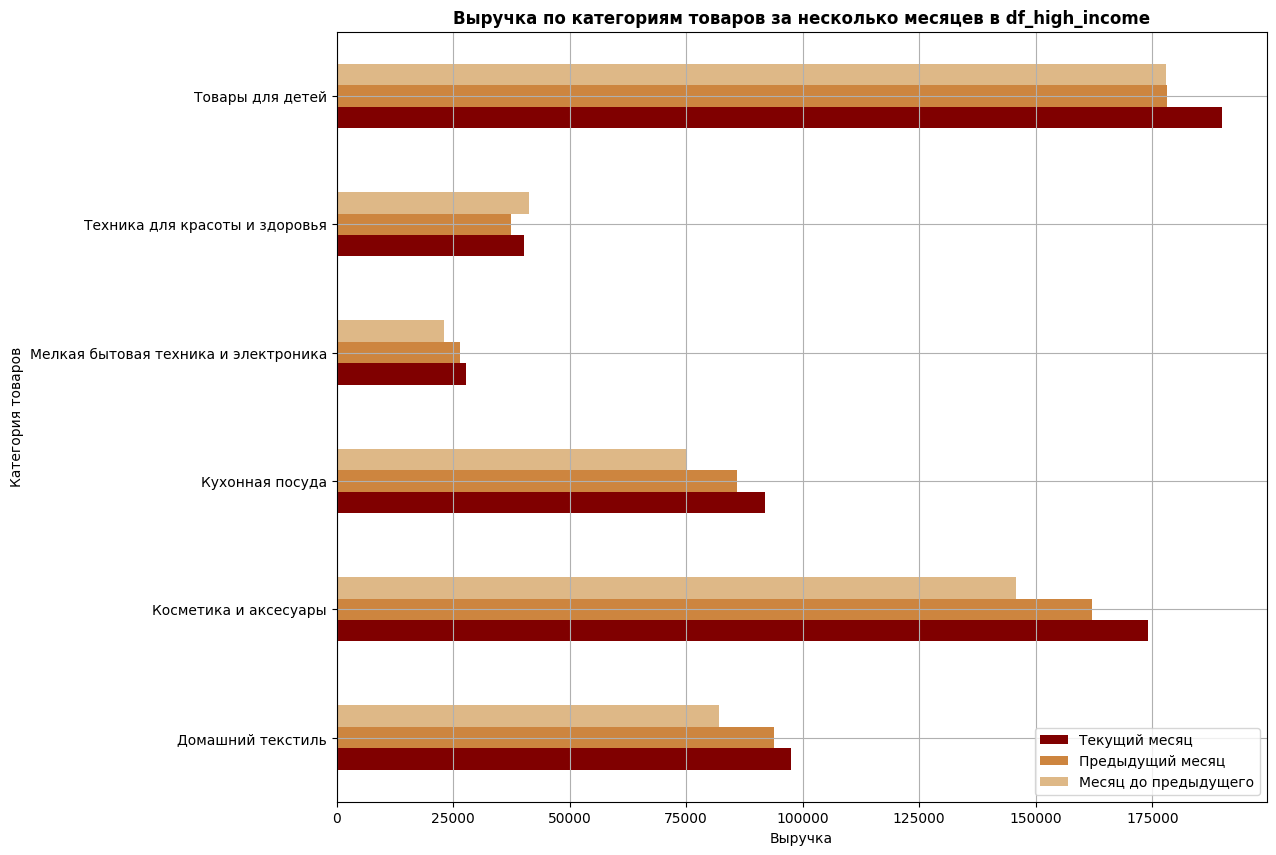

In [ ]:
category_data = pd.concat([df_high_income.groupby('popular_category')[['revenue_current_month', 'revenue_prev_month', 'revenue_before_prev_month']].sum()])

category_data.plot(kind='barh', figsize=(12, 10), color=['Maroon', 'Peru', 'BurlyWood'])
plt.title('Выручка по категориям товаров за несколько месяцев в df_high_income')
plt.xlabel('Выручка')
plt.ylabel('Категория товаров')
plt.legend(['Текущий месяц', 'Предыдущий месяц', 'Месяц до предыдущего'])

plt.show()

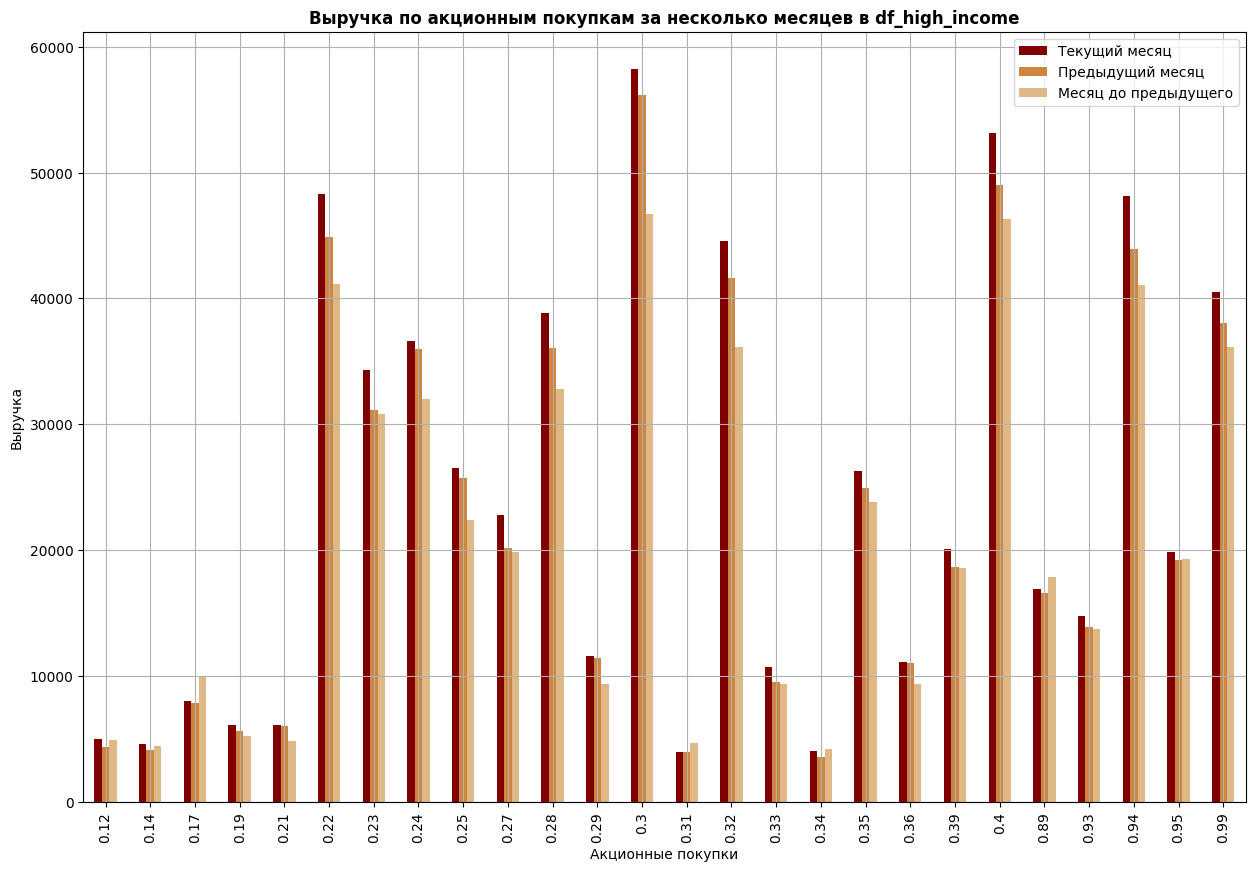

In [ ]:
promo_data = pd.concat([df_high_income.groupby('promo_purchases')[['revenue_current_month', 'revenue_prev_month', 'revenue_before_prev_month']].sum()])
promo_data.plot(kind='bar', figsize=(15, 10), color=['Maroon', 'Peru', 'BurlyWood'])
plt.title('Выручка по акционным покупкам за несколько месяцев в df_high_income')
plt.xlabel('Акционные покупки')
plt.ylabel('Выручка')
plt.legend(['Текущий месяц', 'Предыдущий месяц', 'Месяц до предыдущего'])

plt.show()

In [ ]:
# Посчитаем разницу между текущим и предыдущим месяцами по популярным категориям
revenue_category = df.groupby('popular_category')[['revenue_current_month', 'revenue_prev_month']].sum()
revenue_category['revenue_difference'] = revenue_category['revenue_current_month'] - revenue_category['revenue_prev_month']
revenue_category['revenue_difference_percent'] = (revenue_category['revenue_difference'] / revenue_category['revenue_prev_month']) * 100

revenue_category

revenue_current_month  \
popular_category                                              
Домашний текстиль                                1341309.40   
Косметика и аксесуары                            1199034.70   
Кухонная посуда                                   766812.80   
Мелкая бытовая техника и электроника              920019.30   
Техника для красоты и здоровья                    912412.65   
Товары для детей                                 1654163.60   

                                      revenue_prev_month  revenue_difference  \
popular_category                                                               
Домашний текстиль                              1273835.5            67473.90   
Косметика и аксесуары                          1137351.0            61683.70   
Кухонная посуда                                 718523.0            48289.80   
Мелкая бытовая техника и электроника            874921.0            45098.30   
Техника для красоты и здоровья                  854352.0            58060.65   
Товары для детей                               1559014.0            95149.60   

                                      revenue_difference_percent  
popular_category                                                  
Домашний текстиль                                       5.296908  
Косметика и аксесуары                                   5.423453  
Кухонная посуда                                         6.720703  
Мелкая бытовая техника и электроника                    5.154557  
Техника для красоты и здоровья                          6.795870  
Товары для детей                                        6.103191

**Вывод**

- Категория включает преимущественно покупателей товаров для детей и косметики и аксессуаров (32 % и 27 % соответственно). В то время как в целом на эти категории приходится 25 % и 19 %.

- Тариф `«Премиум»` используют на 11 % больше пользователей, которые приносят высокий доход.

- Пользователи этой группы чаще всего просматривают две категории.

- В среднем они проводят на сайте около 10 минут, что меньше, чем в среднем все пользователи, и просматривают не более 5 страниц за один визит.

- Выручка текущего месяца по популярным категорям в среднем на 5-7% больше предыдущего 

# Общий вывод и рекомендации компании «В один клик»

**Шаг 1. Загрузка данных**

- Все данные представлены корректно и соответствуют описанию. Можно привести столбцы к нижнему регистру, а также обратить внимание на значения в столбцах Период датасетов <u>market_money</u> и <u>market_time</u>. Также стоит учесть значения Тип сервиса датасета <u>market_file</u>. В целом, на первый взгляд, это всё, что нужно сделать для улучшения качества данных.

**Шаг 2. Предобработка данных**

- Мы провели реорганизацию столбцов, преобразовали формат данных в столбце `market_file['market_active_six_month']`, а также устранили дубликаты в наборе данных market_money. Аномальных значений обнаружено не было.

**Шаг 3. Исследовательский анализ данных**

- Изучив графики, мы можем создать портрет ***типичного пользователя***. За последние полгода активность маркетинговых коммуникаций составила 4 взаимодействия. Аналогичное количество маркетинговых активностей наблюдается и в течение месяца. Пользователи с нормальной активностью зарегистрированы на сайте от 300 до 650 дней, и распределение равномерно. Большинство пользователей не использует акции. Чаще всего они просматривают три категории товаров за одно посещение сайта. За три месяца они могут не оплатить от одного до пяти товаров в корзине, причём чаще всего не оплачивается один товар. Количество сбоев в сайте при посещении варьируется от 0 до 9, в среднем составляя 4. Обычно за одно посещение просматривается около девяти страниц.

- Мы также определили профиль ***неактивного пользователя***. Уровень вовлечённости в маркетинговые коммуникации составляет 3 за полгода, при этом количество маркетинговых активностей за месяц равно 4. Большинство пользователей зарегистрировано 800–850 дней назад. Предполагается, что пользователям наскучил сайт. 28–33% пользователей используют акционные товары. Можно предположить, что низкая активность связана с тем, что пользователи предпочитают покупать товары со скидками. За один визит сайта они просматривают две категории товаров. В течение трёх месяцев они могут не оплатить от 1 до 9 товаров, в среднем 3. Количество сбоев в среднем составляет 3. Обычно такие пользователи просматривают 6 страниц за один визит сайта, что логично меньше, чем у среднестатистического пользователя

- Из 6 категорий товаров больший акцент делается на `товары для детей` и `домашний текстиль`, меньший — на `кухонную утварь`.

- Около 62 % клиентов сохраняют свой текущий уровень активности. Более 70 % пользуются базовым уровнем обслуживания и готовы получать дополнительные предложения о товарах.

- Среднестатистический пользователь зарегестрирован на сайте чуть больше полутора года. В течение месяца он сталкивается примерно с четырьмя маркетинговыми активностями, которые предлагает сайт. Обычно этот пользователь не использует специальные предложения или скидки, доступные на сайте.

- Во время использования сайта среднестатистический пользователь сталкивается с 4 сбоями в работе сайта и просматривает в среднем 8 страниц за одно посещение. Его интересуют различные категории товаров, такие как товары для детей, домашний текстиль, косметика и аксессуары. Время пребывания пользователя на сайте составляет от 10 до 15 минут.

- Следует подчеркнуть, что такие аспекты, как количество дней регистрации на сайте, количество просмотренных категорий за визит, число сбоев и среднее количество просмотренных страниц за посещение сайта, указывают на снижение активности пользователей.

**Шаг 4. Объединение таблиц**

- Мы успешно объединили данные

**Шаг 5. Корреляционный анализ**

- Можно сказать, что мультиколлинеарность имеет место, когда коэффициент корреляции между объясняющими переменными составляет 0,9 и более. Все признаки коррелируют в пределах нормы. Наблюдается высокая зависимость между выручкой за предыдущий месяц и выручкой в текущем месяце, однако она ниже 0,9, поэтому её можно оставить.

**Шаг 6. Использование пайплайнов**

- Лучшей моделью на тренировочной выборке оказалась `KNeighborsClassifier` (n_neighbors=8), ее `roc_auc` равен: 0.907
- Метрика `ROC-AUC` на тестовой выборке: 0.897

**Шаг 7. Анализ важности признаков**

- Наибольшее воздействие на модель оказывают количество посещаемых страниц пользователя за визит и количество минут, проведенных им на сайте в предыдущем месяце. Далее следует учитывать акционные покупки, средний просмотр категорий за визит, минуты, проведенные на сайте в текущем месяце, и выручку за предыдущий месяц.

- Наименьшее воздействие на модель оказывают категории товаров и количество маркетинговых коммуникаций в текущем месяце. Следовательно, рекомендуется исключить данные признаки из модели, а на те, которые оказывают наибольшее воздействие, обратить особое внимание при принятии решений. Из полученных данных можно сделать вывод, что посещаемость сайта и время, проведенное на нем, сильнее всего коррелируют на активность пользователей, поэтому эти факторы следует учитывать при принятии решений.

**Шаг 8. Сегментация покупателей**

- Категория включает преимущественно покупателей `товаров для детей` и `косметики и аксессуаров` (34 % и 26 % соответственно). В то время как в целом на эти категории приходится 25 % и 19 %.

- Тариф `«Премиум»` используют на 6 % больше пользователей, которые приносят высокий доход.

- Пользователи этой группы чаще всего просматривают две категории.

- В среднем они проводят на сайте около 10 минут, что меньше, чем в среднем все пользователи, и просматривают не более 5 страниц за один визит.

- Средняя выручка также ниже среднего показателя, однако она растёт к текущему месяцу, что является положительным знаком.

**Рекомендации компании «В один клик»**

1. <u>**Анализируйте данные о времени**</u>, проведённом пользователями на сайте, и количестве просмотренных страниц, чтобы выявить слабые стороны и улучшить пользовательский опыт. Обратите внимание на показатели отказов, длительность сессий и активность посетителей.

2. <u>**Используйте данные о просмотрах категорий и сделанных покупках**</u> для создания персонализированных рекомендаций товаров и услуг. Это поможет пользователям быстрее находить нужную информацию и повысит удовлетворённость от использования сайта.

3. <u>**Предложите специальные акции и скидки**</u> для неактивных покупателей, чтобы стимулировать их активность и увеличить количество покупок. Акции могут быть приурочены к определённым событиям, периодам или категориям товаров.
